In [1]:
# Import necessary libraries
import io
import base64
import numpy as np
from dash import Dash, dcc, html, Input, Output, no_update, callback
import plotly.graph_objects as go
from PIL import Image
from sklearn.manifold import TSNE
import torch
from tqdm import tqdm
import random
import umap

from anomaly_detection.config.config_handler import get_config
from anomaly_detection.data.data_loader import get_data_loader
from anomaly_detection.training.train import train_model
# from anomaly_detection.models.cvae3d_flex import CVAE3D
from anomaly_detection.models.cvae3d import CVAE3D

# Load your configuration
config = get_config('/home/ssulta24/Desktop/VCAE_new/anomaly_detection/config/config.yaml')

# Load your pre-trained model V1
# model = CVAE3D(input_shape=(24, 24, 240), latent_dim=config['latent_dim'], hidden_dims=config['hidden_dims']).to("cuda")
# model.load_state_dict(torch.load('/home/ssulta24/Desktop/VCAE_new/wandb/run-20240823_154222-zcnsqis6/files/final_model.pth', map_location="cuda"))

# Load your pretrained model V2
model = CVAE3D(config).to("cuda")
# model.load_state_dict(torch.load('/home/ssulta24/Desktop/VCAE_new/wandb/run-20240829_115943-jiv9h3kf/files/final_model.pth', map_location="cuda")) # energy_range: [660, 1140] 
# model.load_state_dict(torch.load('/home/ssulta24/Desktop/VCAE_new/wandb/run-20240906_135459-gi5xl43j/files/best_model.pth', map_location="cuda")) # new model with updated data shape
# model.load_state_dict(torch.load('/home/ssulta24/Desktop/VCAE_new/wandb/run-20240906_162134-wj9dkgsw/files/best_model.pth', map_location="cuda")) 

In [2]:
# model.load_state_dict(torch.load('/home/ssulta24/Desktop/VCAE_new/wandb/run-20240927_020759-uuvx6hz8/files/final_model.pth', map_location="cuda")) # trained with MSE loss
# model.load_state_dict(torch.load('/home/ssulta24/Desktop/VCAE_new/wandb/latest-run/files/best_model.pth', map_location="cuda")) # trained with NLL loss
model.load_state_dict(torch.load('/home/ssulta24/Desktop/VCAE_new/wandb/run-20241006_160824-x3tu4esv/files/best_model.pth', map_location="cuda")) # best loss 

model.eval()

/tmp/ipykernel_3243096/375417464.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/home/ssulta24/Desktop/VCAE_new/wandb/run-20241006_160

CVAE3D(
  (encoder): Sequential(
    (0): Conv3d(1, 32, kernel_size=(1, 1, 7), stride=(1, 1, 2), padding=(0, 0, 3))
    (1): ReLU()
    (2): Conv3d(32, 64, kernel_size=(3, 3, 5), stride=(1, 1, 2), padding=(1, 1, 2))
    (3): ReLU()
    (4): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    (5): ReLU()
    (6): Conv3d(128, 256, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    (7): ReLU()
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=755712, out_features=512, bias=True)
    (10): ReLU()
    (11): Linear(in_features=512, out_features=96, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=48, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=755712, bias=True)
    (3): ReLU()
    (4): Unflatten(dim=1, unflattened_size=(256, 6, 6, 82))
    (5): ConvTranspose3d(256, 128, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), output_padding=(1, 1, 1))
    (6): Re

In [4]:
import numpy as np
import hyperspy.api as hs
from skimage.filters import gaussian
from scipy.ndimage import uniform_filter
from torch.utils.data import Dataset, DataLoader
import torch

filepath = config['data_path']
energy_range = [0, 1312]
size = 24
sigma = config['sigma']
xy_window = 3

def load_and_preprocess():
    """
    Load and preprocess the EELS data.

    Returns:
        numpy.ndarray: Preprocessed EELS data
    """
    try:
        raw_data = load_dm_data()
        preprocessed_data = preprocess_3d_images(raw_data)
        print("done")
        return preprocessed_data
    except Exception as e:
        raise

def load_dm_data():
    """
    Load data from a Digital Micrograph file.

    Returns:
        numpy.ndarray: Raw EELS data
    """
    try:
        s = hs.load(filepath)
        data = s.data
        return data
    except Exception as e:
        raise

def preprocess_3d_images(image):
    """
    Preprocess the 3D EELS image.

    Args:
        image (numpy.ndarray): Raw 3D EELS image

    Returns:
        numpy.ndarray: Preprocessed 3D EELS image
    """
    # Apply Gaussian blur
    blurred_image = gaussian(image, sigma=sigma, mode='reflect', preserve_range=True)
    
    # Slice the data array to keep only the desired energy range
    start_pixel = int(energy_range[0] - 0)
    end_pixel = int(energy_range[1] - 0)
    blurred_image = blurred_image[:, :, start_pixel:end_pixel]

    # Apply min-max scaling
    min_val = np.min(blurred_image)
    max_val = np.max(blurred_image)
    normalized_image = (blurred_image - min_val) / (max_val - min_val)
    
    # Apply spatial-spectral smoothing
    smoothed_img = smooth_spatial_spectral(normalized_image)
    
    # Generate sub-images using sliding window
    sub_images = sliding_window(smoothed_img)
    
    # Reshape sub-images for PyTorch (batch_size, channels, height, width, energy)
    reshaped_sub_images = sub_images.reshape(-1, size, size, sub_images.shape[-1])
    
    return reshaped_sub_images.astype('float32')

def smooth_spatial_spectral(arr):
    """
    Apply spatial-spectral smoothing to the image.

    Args:
        arr (numpy.ndarray): Input 3D array

    Returns:
        numpy.ndarray: Smoothed 3D array
    """
    neighborhood_sum = uniform_filter(arr, size=(xy_window, xy_window, 1), mode='reflect')
    neighborhood_count = uniform_filter(np.ones_like(arr), size=(xy_window, xy_window, 1), mode='reflect')
    return neighborhood_sum / neighborhood_count

def sliding_window(data, stride=24):
    """
    Generate sub-images using a sliding window approach.
    
    Args:
        data (numpy.ndarray): Input data of shape (height, width, energy)
        stride (int): Step size for the sliding window
    
    Returns:
        numpy.ndarray: Array of sub-images
    """
    height, width, energy = data.shape
    sub_images = []
    
    for i in range(0, height - size + 1, stride):
        for j in range(0, width - size + 1, stride):
            sub_image = data[i:i+size, j:j+size, :]
            sub_images.append(sub_image)
    
    return np.array(sub_images)

data = load_and_preprocess()
data.shape

WARNING | Hyperspy | `signal_type='EELS'` not understood. See `hs.print_known_signal_types()` for a list of installed signal types or https://github.com/hyperspy/hyperspy-extensions-list for the list of all hyperspy extensions providing signals. (hyperspy.io:744)
WARNING | Hyperspy | `signal_type='EELS'` not understood. See `hs.print_known_signal_types()` for a list of installed signal types or https://github.com/hyperspy/hyperspy-extensions-list for the list of all hyperspy extensions providing signals. (hyperspy.io:744)
done


(64, 24, 24, 1312)

In [3]:
from anomaly_detection.data.data_loader_V2 import EELSDataset, get_data_loader
from anomaly_detection.config.config_handler import get_config

data = EELSDataset(config)
dataset = data.get_training_sub_images()
dataset = dataset.squeeze(axis=1)
dataset.shape

anom_dataset = data.get_anomaly_sub_images()
anom_dataset = anom_dataset.squeeze(axis=1)
anom_dataset.shape

WARNING | Hyperspy | `signal_type='EELS'` not understood. See `hs.print_known_signal_types()` for a list of installed signal types or https://github.com/hyperspy/hyperspy-extensions-list for the list of all hyperspy extensions providing signals. (hyperspy.io:744)
WARNING | Hyperspy | `signal_type='EELS'` not understood. See `hs.print_known_signal_types()` for a list of installed signal types or https://github.com/hyperspy/hyperspy-extensions-list for the list of all hyperspy extensions providing signals. (hyperspy.io:744)


(1, 24, 24, 1312)

In [4]:
energy_values = data.get_cropped_energy_values()
print(f"Energy range: {energy_values[0]} to {energy_values[-1]} eV, Length: {len(energy_values)}")

Energy range: 423.30001682043076 to 816.6000324487686 eV, Length: 1312


Analyzing original spectrum:
Number of peaks found: 96
Properties returned: dict_keys([])
Prominences not calculated. Using peak heights instead.

Analyzing prediction spectrum:
Number of peaks found: 67
Properties returned: dict_keys([])
Prominences not calculated. Using peak heights instead.


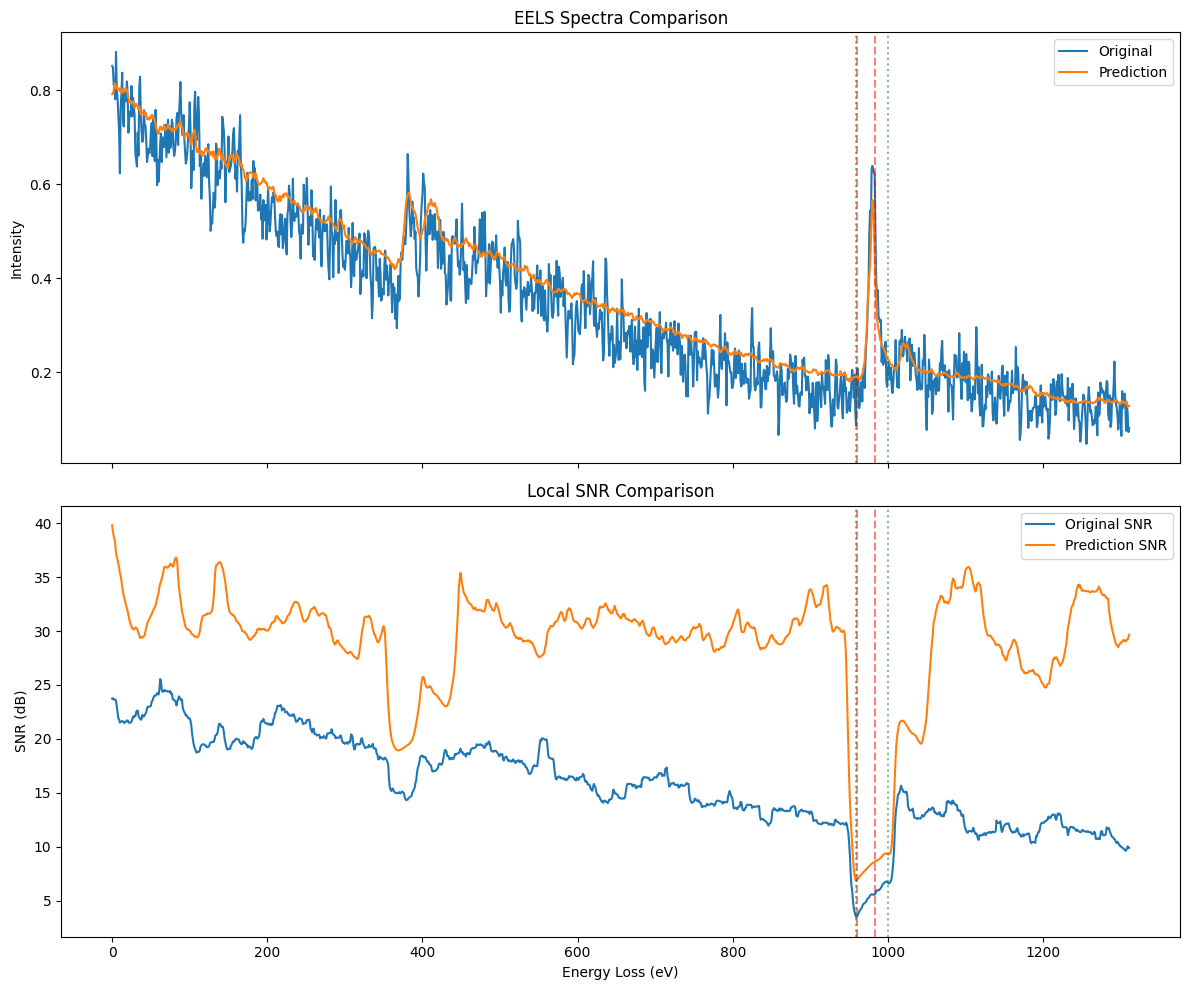

Original spectrum top 2 dips: [960, 983]
Prediction spectrum top 2 dips: [959, 1000]


In [11]:
def make_prediction(model, input_data, device = 'cuda'): 
    model.eval()
    with torch.no_grad():
        input_tensor = torch.tensor(input_data).unsqueeze(1).float().to(device)
        mean, logvar = model.encode(input_tensor)
        z = model.reparameterize(mean, logvar)
        prediction = model.decode(z)
        prediction_np = prediction.squeeze(1).cpu().numpy()
    return prediction_np

prediction_np = make_prediction(model, dataset)

input_sub_image = dataset[19]
prediction_sub_image = prediction_np[19]

import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

def calculate_local_snr(spectrum, window_size=10):
    """Calculate local SNR using a sliding window."""
    local_snr = np.zeros_like(spectrum, dtype=float)
    padded_spectrum = np.pad(spectrum, (window_size//2, window_size//2), mode='edge')
    
    for i in range(len(spectrum)):
        window = padded_spectrum[i:i+window_size]
        signal_power = np.mean(window)**2
        noise_power = np.var(window)
        snr = signal_power / noise_power if noise_power != 0 else float('inf')
        local_snr[i] = 10 * np.log10(snr)
    
    return local_snr

def find_top_2_snr_dips(local_snr, distance=10):
    """Find the top 2 most prominent dips in SNR."""
    inverted_snr = -local_snr  # Invert the SNR to turn dips into peaks
    peaks, properties = signal.find_peaks(inverted_snr, distance=distance)
    
    print(f"Number of peaks found: {len(peaks)}")
    print(f"Properties returned: {properties.keys()}")
    
    if len(peaks) == 0:
        print("No peaks found.")
        return []
    elif len(peaks) == 1:
        print("Only one peak found.")
        return peaks
    else:
        if 'prominences' not in properties:
            print("Prominences not calculated. Using peak heights instead.")
            # Use peak heights if prominences are not available
            peak_heights = inverted_snr[peaks]
            sorted_peaks = sorted(zip(peaks, peak_heights), key=lambda x: x[1], reverse=True)
        else:
            print("Using prominences to sort peaks.")
            sorted_peaks = sorted(zip(peaks, properties['prominences']), key=lambda x: x[1], reverse=True)
        
        return [p[0] for p in sorted_peaks[:2]]

def analyze_snr_dips(original_data, prediction_data, pixel_coords, window_size=50, distance=10):
    x, y = pixel_coords
    original_spectrum = original_data[x, y, :]
    prediction_spectrum = prediction_data[x, y, :]
    
    original_local_snr = calculate_local_snr(original_spectrum, window_size)
    prediction_local_snr = calculate_local_snr(prediction_spectrum, window_size)
    
    print("Analyzing original spectrum:")
    original_dips = find_top_2_snr_dips(original_local_snr, distance)
    print("\nAnalyzing prediction spectrum:")
    prediction_dips = find_top_2_snr_dips(prediction_local_snr, distance)
    
    return {
        'original_spectrum': original_spectrum,
        'prediction_spectrum': prediction_spectrum,
        'original_local_snr': original_local_snr,
        'prediction_local_snr': prediction_local_snr,
        'original_dips': original_dips,
        'prediction_dips': prediction_dips
    }

def plot_snr_dip_results(results):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
    
    # Plot spectra
    ax1.plot(results['original_spectrum'], label='Original')
    ax1.plot(results['prediction_spectrum'], label='Prediction')
    ax1.set_title('EELS Spectra Comparison')
    ax1.set_ylabel('Intensity')
    ax1.legend()
    
    # Highlight dips in the spectra
    for dip in results['original_dips']:
        ax1.axvline(x=dip, color='r', linestyle='--', alpha=0.5)
    for dip in results['prediction_dips']:
        ax1.axvline(x=dip, color='g', linestyle=':', alpha=0.5)
    
    # Plot local SNR
    ax2.plot(results['original_local_snr'], label='Original SNR')
    ax2.plot(results['prediction_local_snr'], label='Prediction SNR')
    ax2.set_title('Local SNR Comparison')
    ax2.set_xlabel('Energy Loss (eV)')
    ax2.set_ylabel('SNR (dB)')
    ax2.legend()
    
    # Highlight dips in the SNR plot
    for dip in results['original_dips']:
        ax2.axvline(x=dip, color='r', linestyle='--', alpha=0.5)
    for dip in results['prediction_dips']:
        ax2.axvline(x=dip, color='g', linestyle=':', alpha=0.5)
    
    plt.tight_layout()
    plt.show()
    
    # Print dip locations
    print("Original spectrum top 2 dips:", results['original_dips'])
    print("Prediction spectrum top 2 dips:", results['prediction_dips'])

# Usage example
pixel_coords = (10, 10)  # Example coordinates, adjust as needed
results = analyze_snr_dips(input_sub_image, prediction_sub_image, pixel_coords, distance=10)
plot_snr_dip_results(results)

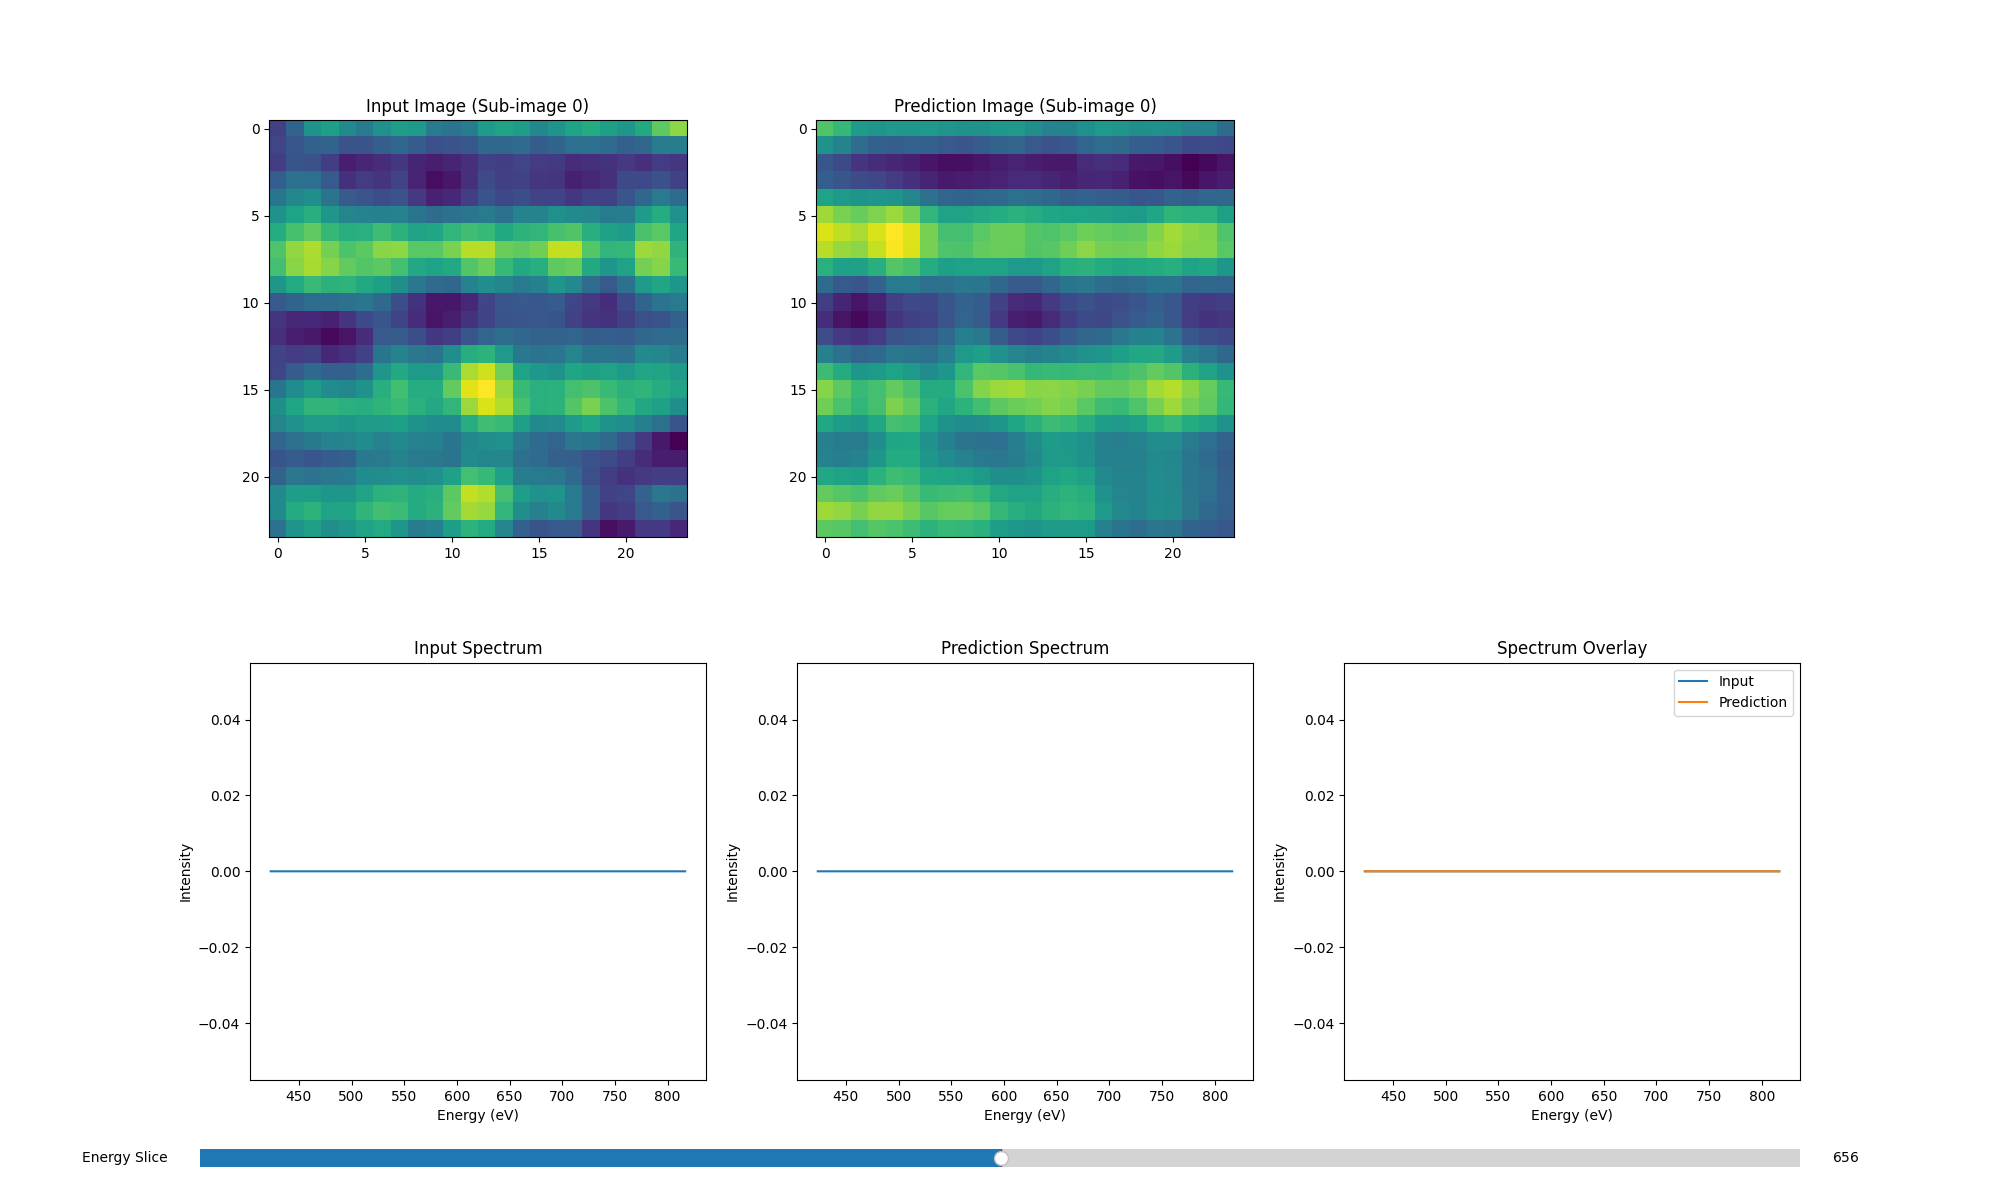

In [5]:
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
import torch
%matplotlib widget

def interactive_eels_visualization(model, input_data, device='cuda', sub_image_index=0):
    """
    Create an interactive visualization for EELS data comparison, including model prediction.
    
    Args:
    model (torch.nn.Module): The trained VAE model
    input_data (numpy.ndarray): The input data (shape: num_sub_images x height x width x energy)
    energy_range (tuple): The energy range (start, end) in eV for the full spectrum
    device (str): The device to run the model on ('cuda' or 'cpu')
    sub_image_index (int): Index of the sub-image to visualize (default: 0)
    
    Returns:
    None (displays the interactive plot)
    """
    # Ensure the model is in evaluation mode
    model.eval()
    
    # Generate prediction
    with torch.no_grad():
        input_tensor = torch.tensor(input_data).unsqueeze(1).float().to(device)
        mean, logvar = model.encode(input_tensor)
        z = model.reparameterize(mean, logvar)
        prediction = model.decode(z)
        prediction_np = prediction.squeeze(1).cpu().numpy()
    
    # Select a single sub-image
    input_sub_image = input_data[sub_image_index]
    prediction_sub_image = prediction_np[sub_image_index]
    
    # Ensure input and prediction have the same shape
    assert input_sub_image.shape == prediction_sub_image.shape, "Input and prediction shapes do not match"
    
    # # Create energy array
    # energy_values = np.linspace(energy_range[0], energy_range[1], input_sub_image.shape[2])
    
    # Create the main figure
    fig, axs = plt.subplots(2, 3, figsize=(20, 12))
    plt.subplots_adjust(bottom=0.1, top=0.9, hspace=0.3)
    
    # Plot input and prediction images (sum along energy axis)
    input_img = axs[0, 0].imshow(np.sum(input_sub_image, axis=2), cmap='viridis')
    axs[0, 0].set_title(f'Input Image (Sub-image {sub_image_index})')
    pred_img = axs[0, 1].imshow(np.sum(prediction_sub_image, axis=2), cmap='viridis')
    axs[0, 1].set_title(f'Prediction Image (Sub-image {sub_image_index})')
    
    # Create empty line plots for spectra
    input_spectrum, = axs[1, 0].plot(energy_values, np.zeros_like(energy_values))
    axs[1, 0].set_title('Input Spectrum')
    axs[1, 0].set_xlabel('Energy (eV)')
    axs[1, 0].set_ylabel('Intensity')
    
    pred_spectrum, = axs[1, 1].plot(energy_values, np.zeros_like(energy_values))
    axs[1, 1].set_title('Prediction Spectrum')
    axs[1, 1].set_xlabel('Energy (eV)')
    axs[1, 1].set_ylabel('Intensity')
    
    overlay_input, = axs[1, 2].plot(energy_values, np.zeros_like(energy_values), label='Input')
    overlay_pred, = axs[1, 2].plot(energy_values, np.zeros_like(energy_values), label='Prediction')
    axs[1, 2].set_title('Spectrum Overlay')
    axs[1, 2].set_xlabel('Energy (eV)')
    axs[1, 2].set_ylabel('Intensity')
    axs[1, 2].legend()
    
    # Remove the unused subplot
    fig.delaxes(axs[0, 2])
    
    # Create a slider for adjusting the energy slice
    ax_slider = plt.axes([0.1, 0.02, 0.8, 0.03])
    slider = Slider(ax_slider, 'Energy Slice', 0, input_sub_image.shape[2]-1, valinit=input_sub_image.shape[2]//2, valstep=1)
    
    # Function to update images based on slider
    def update_slice(val):
        slice_index = int(slider.val)
        input_img.set_array(input_sub_image[:, :, slice_index])
        pred_img.set_array(prediction_sub_image[:, :, slice_index])
        fig.canvas.draw_idle()
    
    slider.on_changed(update_slice)
    
    # Function to update spectra on mouse hover
    def update_spectra(event):
        if event.inaxes in [axs[0, 0], axs[0, 1]]:
            x, y = int(event.xdata), int(event.ydata)
            if 0 <= x < input_sub_image.shape[1] and 0 <= y < input_sub_image.shape[0]:
                input_spectrum.set_ydata(input_sub_image[y, x, :])
                pred_spectrum.set_ydata(prediction_sub_image[y, x, :])
                overlay_input.set_ydata(input_sub_image[y, x, :])
                overlay_pred.set_ydata(prediction_sub_image[y, x, :])
                
                for ax in [axs[1, 0], axs[1, 1], axs[1, 2]]:
                    ax.relim()
                    ax.autoscale_view()
                
                fig.canvas.draw_idle()
    
    fig.canvas.mpl_connect('motion_notify_event', update_spectra)
    
    plt.show()

interactive_eels_visualization(model, anom_dataset, device="cuda", sub_image_index=0)

In [6]:
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
import torch
import numpy as np
from sklearn.decomposition import PCA
%matplotlib widget

def interactive_eels_visualization(model, input_data, energy_range, device='cuda', sub_image_index=0, n_components=5):
    """
    Create an interactive visualization for EELS data comparison, including model prediction and PCA reconstruction.
    
    Args:
    model (torch.nn.Module): The trained VAE model
    input_data (numpy.ndarray): The input data (shape: num_sub_images x height x width x energy)
    energy_range (tuple): The energy range (start, end) in eV for the full spectrum
    device (str): The device to run the model on ('cuda' or 'cpu')
    sub_image_index (int): Index of the sub-image to visualize (default: 0)
    n_components (int): Number of PCA components to use for reconstruction (default: 5)
    
    Returns:
    None (displays the interactive plot)
    """
    # Ensure the model is in evaluation mode
    model.eval()
    
    # Generate VAE prediction
    with torch.no_grad():
        input_tensor = torch.tensor(input_data).unsqueeze(1).float().to(device)
        mean, logvar = model.encode(input_tensor)
        z = model.reparameterize(mean, logvar)
        prediction = model.decode(z)
        prediction_np = prediction.squeeze(1).cpu().numpy()
    
    # Perform PCA reconstruction
    pca = PCA(n_components=n_components)
    flattened_data = input_data.reshape(input_data.shape[0], -1)
    pca_result = pca.fit_transform(flattened_data)
    pca_reconstruction = pca.inverse_transform(pca_result).reshape(input_data.shape)
    
    # Select a single sub-image
    input_sub_image = input_data[sub_image_index]
    prediction_sub_image = prediction_np[sub_image_index]
    pca_sub_image = pca_reconstruction[sub_image_index]
    
    # Ensure input, prediction, and PCA reconstruction have the same shape
    assert input_sub_image.shape == prediction_sub_image.shape == pca_sub_image.shape, "Shapes do not match"
    
    # Create energy array
    energy_values = np.linspace(energy_range[0], energy_range[1], input_sub_image.shape[2])
    
    # Create the main figure
    fig, axs = plt.subplots(2, 4, figsize=(25, 12))
    plt.subplots_adjust(bottom=0.1, top=0.9, hspace=0.3, wspace=0.3)
    
    # Plot input, VAE prediction, and PCA reconstruction images (sum along energy axis)
    input_img = axs[0, 0].imshow(np.sum(input_sub_image, axis=2), cmap='viridis')
    axs[0, 0].set_title(f'Input Image (Sub-image {sub_image_index})')
    pred_img = axs[0, 1].imshow(np.sum(prediction_sub_image, axis=2), cmap='viridis')
    axs[0, 1].set_title(f'VAE Prediction (Sub-image {sub_image_index})')
    pca_img = axs[0, 2].imshow(np.sum(pca_sub_image, axis=2), cmap='viridis')
    axs[0, 2].set_title(f'PCA Reconstruction (Sub-image {sub_image_index})')
    
    # Remove the unused subplot
    fig.delaxes(axs[0, 3])
    
    # Create empty line plots for spectra
    input_spectrum, = axs[1, 0].plot(energy_values, np.zeros_like(energy_values))
    axs[1, 0].set_title('Input Spectrum')
    axs[1, 0].set_xlabel('Energy (eV)')
    axs[1, 0].set_ylabel('Intensity')
    
    pred_spectrum, = axs[1, 1].plot(energy_values, np.zeros_like(energy_values))
    axs[1, 1].set_title('VAE Prediction Spectrum')
    axs[1, 1].set_xlabel('Energy (eV)')
    axs[1, 1].set_ylabel('Intensity')
    
    pca_spectrum, = axs[1, 2].plot(energy_values, np.zeros_like(energy_values))
    axs[1, 2].set_title('PCA Reconstruction Spectrum')
    axs[1, 2].set_xlabel('Energy (eV)')
    axs[1, 2].set_ylabel('Intensity')
    
    overlay_input, = axs[1, 3].plot(energy_values, np.zeros_like(energy_values), label='Input')
    overlay_pred, = axs[1, 3].plot(energy_values, np.zeros_like(energy_values), label='VAE')
    overlay_pca, = axs[1, 3].plot(energy_values, np.zeros_like(energy_values), label='PCA')
    axs[1, 3].set_title('Spectrum Overlay')
    axs[1, 3].set_xlabel('Energy (eV)')
    axs[1, 3].set_ylabel('Intensity')
    axs[1, 3].legend()
    
    # Create a slider for adjusting the energy slice
    ax_slider = plt.axes([0.1, 0.02, 0.8, 0.03])
    slider = Slider(ax_slider, 'Energy Slice', 0, input_sub_image.shape[2]-1, valinit=input_sub_image.shape[2]//2, valstep=1)
    
    # Function to update images based on slider
    def update_slice(val):
        slice_index = int(slider.val)
        input_img.set_array(input_sub_image[:, :, slice_index])
        pred_img.set_array(prediction_sub_image[:, :, slice_index])
        pca_img.set_array(pca_sub_image[:, :, slice_index])
        fig.canvas.draw_idle()
    
    slider.on_changed(update_slice)
    
    # Function to update spectra on mouse hover
    def update_spectra(event):
        if event.inaxes in [axs[0, 0], axs[0, 1], axs[0, 2]]:
            x, y = int(event.xdata), int(event.ydata)
            if 0 <= x < input_sub_image.shape[1] and 0 <= y < input_sub_image.shape[0]:
                input_spectrum.set_ydata(input_sub_image[y, x, :])
                pred_spectrum.set_ydata(prediction_sub_image[y, x, :])
                pca_spectrum.set_ydata(pca_sub_image[y, x, :])
                overlay_input.set_ydata(input_sub_image[y, x, :])
                overlay_pred.set_ydata(prediction_sub_image[y, x, :])
                overlay_pca.set_ydata(pca_sub_image[y, x, :])
                
                for ax in axs[1, :]:
                    ax.relim()
                    ax.autoscale_view()
                
                fig.canvas.draw_idle()
    
    fig.canvas.mpl_connect('motion_notify_event', update_spectra)
    
    plt.show()

# Usage
interactive_eels_visualization(model, data, energy_range, device="cuda", sub_image_index=19, n_components=5)

NameError: name 'energy_range' is not defined

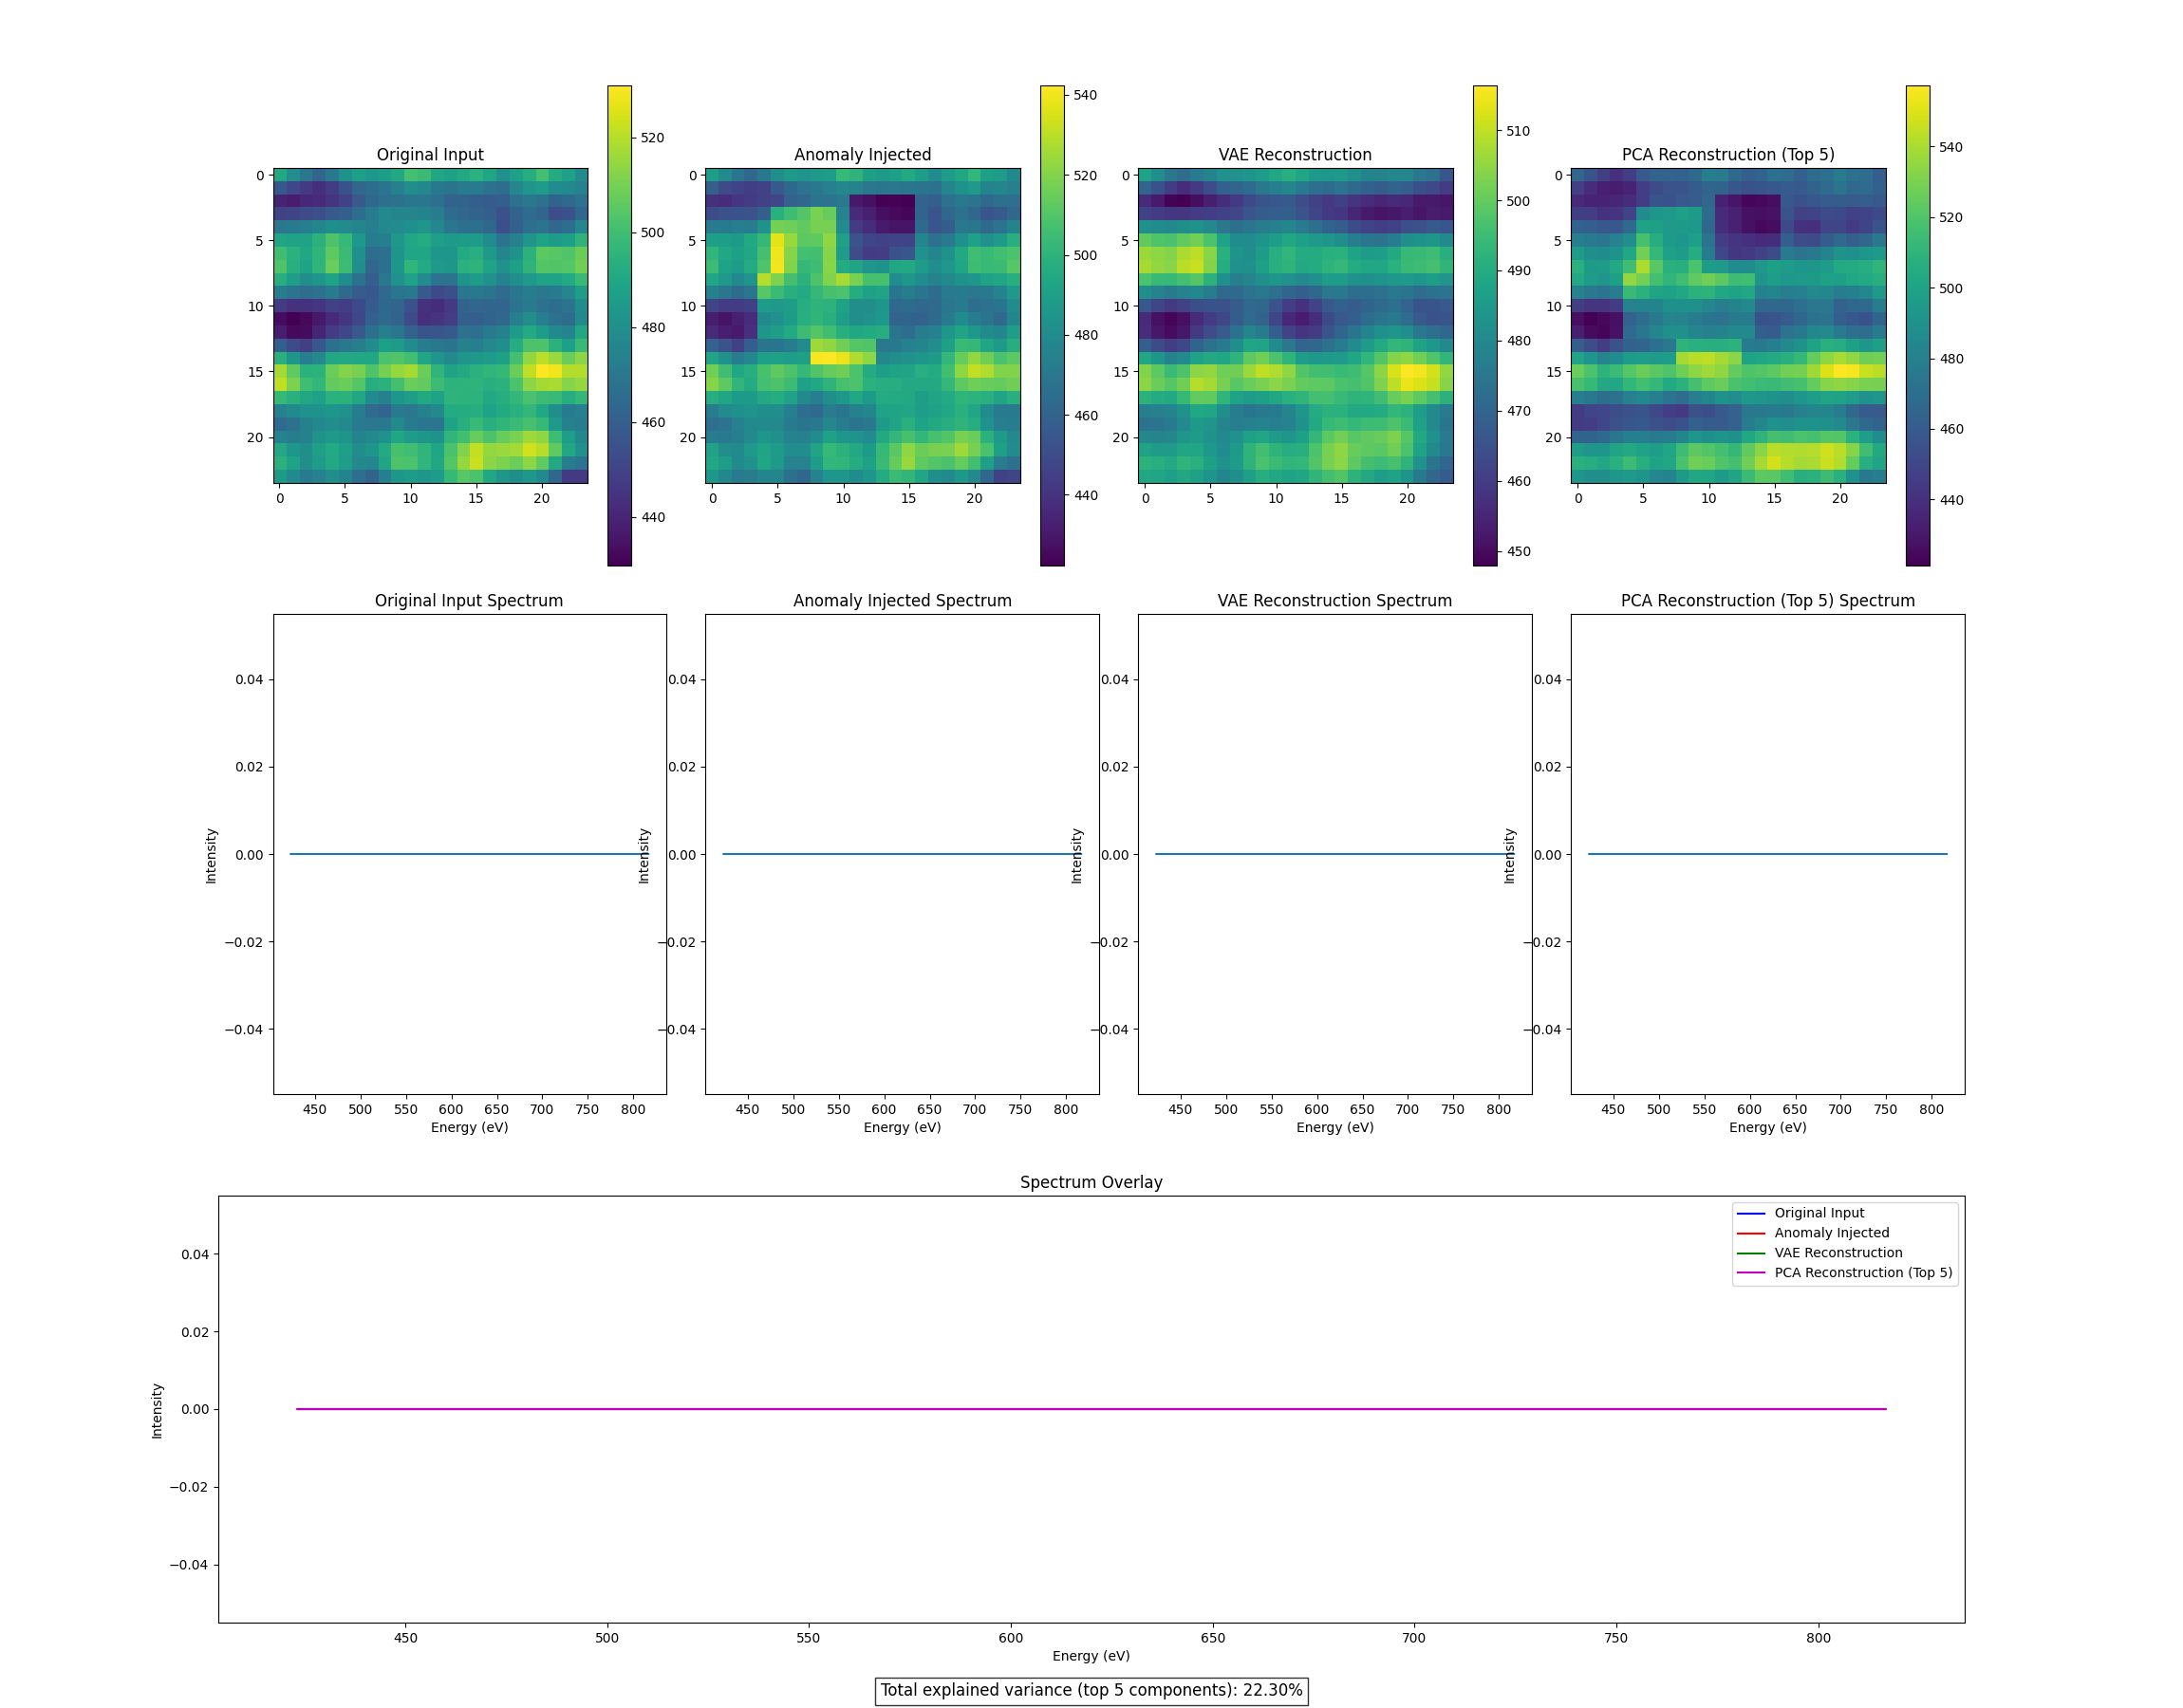

In [8]:
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
import torch
import numpy as np
from sklearn.decomposition import PCA
%matplotlib widget

def inject_anomalies(image, num_clusters=5, cluster_size=4, shift_amount=60, noise_factor=0.09, peak_reduction_factor=0.1, peak_reduction_probability=0):
    """
    Inject anomalies into the EELS image with added noise and peak reduction options.
    
    Args:
    image (numpy.ndarray): Input image of shape (height, width, energy_channels)
    num_clusters (int): Number of anomalous clusters to inject
    cluster_size (int): Size of each anomalous cluster
    shift_amount (int): Amount to shift the peak (in energy channels)
    noise_factor (float): Factor to control the amount of noise added (0 to 1)
    peak_reduction_factor (float): Factor to reduce peak intensity (0 to 1)
    peak_reduction_probability (float): Probability of applying peak reduction to a cluster (0 to 1)
    
    Returns:
    tuple: (anomalous_image, anomaly_mask)
        anomalous_image (numpy.ndarray): Image with injected anomalies, noise, and peak reductions
        anomaly_mask (numpy.ndarray): Boolean mask indicating anomalous pixels
    """
    anomalous_image = np.copy(image)
    height, width, channels = image.shape
    anomaly_mask = np.zeros((height, width), dtype=bool)
    
    # Add global noise
    noise = np.random.normal(0, noise_factor * np.mean(image), image.shape)
    anomalous_image += noise
    
    for _ in range(num_clusters):
        # Choose a random center for the cluster
        center_y = np.random.randint(cluster_size, height - cluster_size)
        center_x = np.random.randint(cluster_size, width - cluster_size)
        
        # Define the cluster region
        y_start, y_end = center_y - cluster_size // 2, center_y + cluster_size // 2 + 1
        x_start, x_end = center_x - cluster_size // 2, center_x + cluster_size // 2 + 1
        
        # Mark the cluster region as anomalous
        anomaly_mask[y_start:y_end, x_start:x_end] = True
        
        # Shift the peak
        if np.random.random() < 0.5:  # 50% chance to shift left or right
            anomalous_image[y_start:y_end, x_start:x_end, :-shift_amount] = image[y_start:y_end, x_start:x_end, shift_amount:]
        else:
            anomalous_image[y_start:y_end, x_start:x_end, shift_amount:] = image[y_start:y_end, x_start:x_end, :-shift_amount]
        
        # Randomly reduce peak intensity
        if np.random.random() < peak_reduction_probability:
            peak_intensity = np.max(anomalous_image[y_start:y_end, x_start:x_end])
            reduction_amount = peak_intensity * peak_reduction_factor
            anomalous_image[y_start:y_end, x_start:x_end] -= reduction_amount
    
    # Ensure all values are non-negative
    anomalous_image = np.clip(anomalous_image, 0, None)
    
    return anomalous_image, anomaly_mask

def interactive_eels_visualization(model, input_data, device='cuda', sub_image_index=0, n_pca_fit=30, n_pca_reconstruct=5):
    """
    Create an interactive visualization for EELS data comparison, including model prediction and PCA reconstruction
    based on anomaly-injected data, using only the top PCA components.
    """
    model.eval()
    
    # Select the sub-image and inject anomalies
    input_sub_image = input_data[sub_image_index]
    anomalous_sub_image, anomaly_mask = inject_anomalies(input_sub_image)
    
    # Create a modified version of input_data with the anomalous sub-image
    modified_input_data = input_data.copy()
    modified_input_data[sub_image_index] = anomalous_sub_image
    # modified_input_data = np.delete(input_data, sub_image_index, axis=0)
    
    # Generate VAE prediction for anomalous data
    with torch.no_grad():
        anomalous_tensor = torch.tensor(anomalous_sub_image).unsqueeze(0).unsqueeze(0).float().to(device)
        
        mean, logvar = model.encode(anomalous_tensor)
        z = model.reparameterize(mean, logvar)
        prediction_sub_image = model.decode(z).squeeze().cpu().numpy()
    
    # Perform PCA
    pca = PCA(n_components=n_pca_fit)
    flattened_data = modified_input_data.reshape(modified_input_data.shape[0], -1)
    pca_result = pca.fit_transform(flattened_data)
    
    # Reconstruct using only the top n_pca_reconstruct components
    top_components = pca_result[:, :n_pca_reconstruct]
    reduced_components = pca.components_[:n_pca_reconstruct, :]
    pca_reconstruction = np.dot(top_components, reduced_components) + pca.mean_
    pca_reconstruction = pca_reconstruction.reshape(modified_input_data.shape)
    pca_sub_image = pca_reconstruction[sub_image_index]
    
    # Calculate explained variance ratio
    explained_variance_ratio = pca.explained_variance_ratio_
    total_explained_variance = np.sum(explained_variance_ratio[:n_pca_reconstruct])
    
    # # Create energy array
    # energy_values = np.linspace(energy_range[0], energy_range[1], input_sub_image.shape[2])
    
    # Create the main figure
    fig, axs = plt.subplots(3, 4, figsize=(23, 18), gridspec_kw={'height_ratios': [1, 1, 1]})
    plt.subplots_adjust(bottom=0.05, top=0.95, hspace=0.1, wspace=0.1)
    
    # Plot images
    images = [input_sub_image, anomalous_sub_image, prediction_sub_image, pca_sub_image]
    titles = ['Original Input', 'Anomaly Injected', 'VAE Reconstruction', f'PCA Reconstruction (Top {n_pca_reconstruct})']
    for i, (img, title) in enumerate(zip(images, titles)):
        im = axs[0, i].imshow(np.sum(img, axis=2), cmap='viridis')
        axs[0, i].set_title(title)
        plt.colorbar(im, ax=axs[0, i])
    
    # Create empty line plots for spectra
    spectra = []
    for i, title in enumerate(titles):
        spec, = axs[1, i].plot(energy_values, np.zeros_like(energy_values))
        axs[1, i].set_title(f'{title} Spectrum')
        axs[1, i].set_xlabel('Energy (eV)')
        axs[1, i].set_ylabel('Intensity')
        spectra.append(spec)
    
    # Create overlay plot
    overlay_specs = []
    colors = ['b', 'r', 'g', 'm']
    for color, title in zip(colors, titles):
        spec, = axs[2, 0].plot(energy_values, np.zeros_like(energy_values), color=color, label=title)
        overlay_specs.append(spec)
    axs[2, 0].set_title('Spectrum Overlay')
    axs[2, 0].set_xlabel('Energy (eV)')
    axs[2, 0].set_ylabel('Intensity')
    axs[2, 0].legend()
    
    # Remove unused subplots
    for ax in axs[2, 1:]:
        fig.delaxes(ax)
    
    # Adjust overlay plot to span full width
    axs[2, 0].set_position([0.1, 0.05, 0.8, 0.25])
    
    # Add text to show explained variance
    fig.text(0.5, 0.01, f'Total explained variance (top {n_pca_reconstruct} components): {total_explained_variance:.2%}', 
             ha='center', va='center', fontsize=12, bbox=dict(facecolor='white', alpha=0.8))
    
    # Function to update spectra on mouse hover
    def update_spectra(event):
        for ax in axs[0]:
            if event.inaxes == ax:
                x, y = int(event.xdata), int(event.ydata)
                if 0 <= x < input_sub_image.shape[1] and 0 <= y < input_sub_image.shape[0]:
                    pixel_spectra = [img[y, x, :] for img in images]
                    
                    # Calculate min and max for this pixel across all spectra
                    pixel_min = min(spec.min() for spec in pixel_spectra)
                    pixel_max = max(spec.max() for spec in pixel_spectra)
                    
                    for spec, pixel_spectrum in zip(spectra, pixel_spectra):
                        spec.set_ydata(pixel_spectrum)
                    
                    # Add small offsets to separate overlapping lines
                    offsets = np.linspace(0, (pixel_max - pixel_min) * 0.1, len(overlay_specs))
                    for overlay_spec, pixel_spectrum, offset in zip(overlay_specs, pixel_spectra, offsets):
                        overlay_spec.set_ydata(pixel_spectrum + offset)
                    
                    for ax in axs[1]:
                        ax.relim()
                        ax.autoscale_view()
                    
                    # Set y-axis limits for overlay plot based on this pixel's spectra
                    axs[2, 0].set_ylim(pixel_min, pixel_max * 1.1)  # Add 10% to the top for offsets
                    axs[2, 0].relim()
                    axs[2, 0].autoscale_view()
                    
                    # Add text to show current pixel coordinates
                    axs[2, 0].set_title(f'Spectrum Overlay (Pixel: {x}, {y})')
                    
                    fig.canvas.draw_idle()
                break
    
    fig.canvas.mpl_connect('motion_notify_event', update_spectra)
    
    plt.show()
    
    return pca, modified_input_data, anomaly_mask

# Usage
pca, modified_anomalous_data, anomaly_mask = interactive_eels_visualization(model, dataset, device="cuda", sub_image_index=19, n_pca_fit=30, n_pca_reconstruct=5)

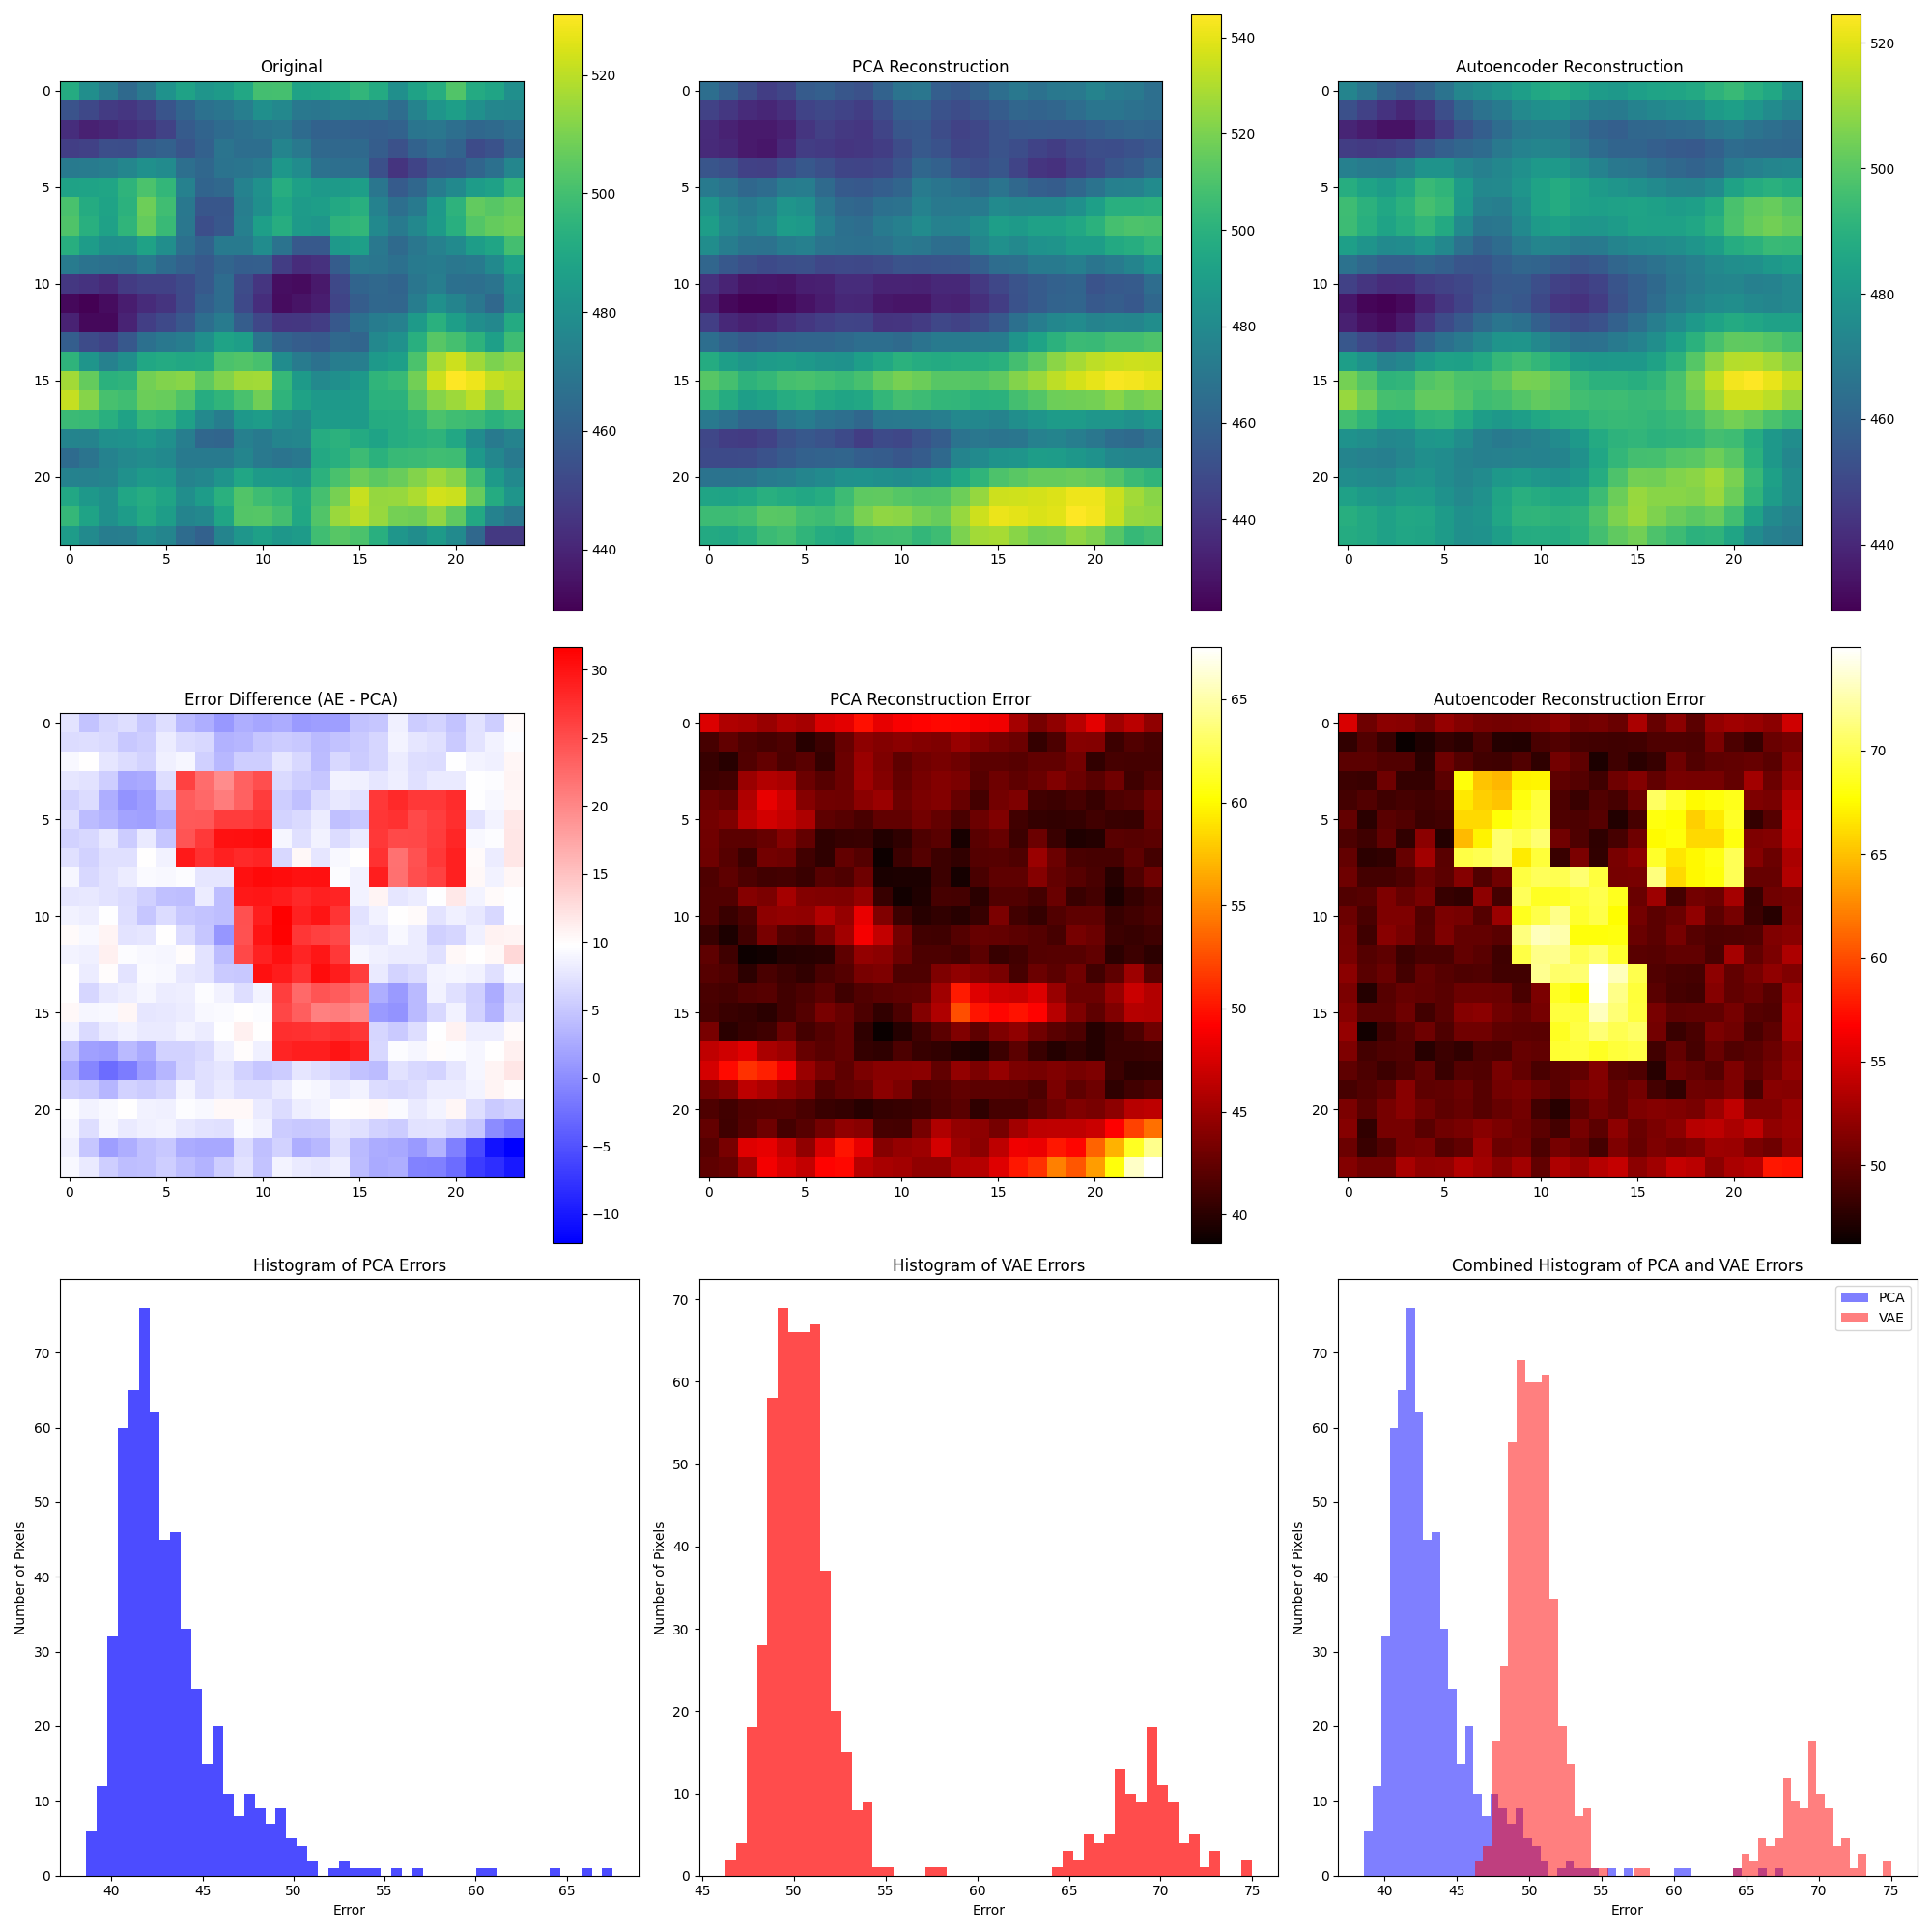

PCA Mean Error: 43.3067
Autoencoder Mean Error: 53.7089
Max PCA Error: 67.5382
Max Autoencoder Error: 74.9938


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.decomposition import PCA

def compare_reconstruction_errors(model, input_data, pcau, sub_image_index, device='cuda'):
    """
    Compare reconstruction errors between PCA and Autoencoder with raw error maps and histograms.
    
    Args:
    model (torch.nn.Module): The trained VAE model
    input_data (numpy.ndarray): The input data (shape: num_sub_images x height x width x energy)
    pcau (sklearn.decomposition.PCA): Fitted PCA object
    sub_image_index (int): Index of the sub-image to visualize
    device (str): The device to run the model on ('cuda' or 'cpu')
    
    Returns:
    None (displays the plot)
    """
    # Select the sub-image
    input_sub_image = input_data[sub_image_index]

    # Perform PCA
    pca = PCA(n_components=30)
    flattened_data = input_data.reshape(input_data.shape[0], -1)
    pca_result = pca.fit_transform(flattened_data)
    
    # Reconstruct using only the top 5 components
    top_components = pca_result[:, :5]
    reduced_components = pca.components_[:5, :]
    pca_reconstruction = np.dot(top_components, reduced_components) + pca.mean_
    pca_reconstruction = pca_reconstruction.reshape(input_data.shape)
    pca_sub_image = pca_reconstruction[sub_image_index]

    # Autoencoder reconstruction
    with torch.no_grad():
        input_tensor = torch.tensor(input_sub_image).unsqueeze(0).unsqueeze(0).float().to(device)
        reconstructed, _, _ = model(input_tensor)
        ae_reconstruction = reconstructed.squeeze().cpu().numpy()

    # Calculate reconstruction errors
    pca_error = np.abs(input_sub_image - pca_sub_image)
    ae_error = np.abs(input_sub_image - ae_reconstruction)

    # Calculate error maps (sum along energy axis)
    pca_error_map = np.sum(pca_error, axis=-1)
    ae_error_map = np.sum(ae_error, axis=-1)

    # Calculate error difference
    error_diff = ae_error_map - pca_error_map

    # Plotting
    fig, axs = plt.subplots(3, 3, figsize=(20, 20))
    plt.subplots_adjust(wspace=0.3, hspace=0.4)

    # Original image
    im_orig = axs[0, 0].imshow(np.sum(input_sub_image, axis=-1), cmap='viridis')
    axs[0, 0].set_title("Original")
    plt.colorbar(im_orig, ax=axs[0, 0])

    # PCA reconstruction
    im_pca = axs[0, 1].imshow(np.sum(pca_sub_image, axis=-1), cmap='viridis')
    axs[0, 1].set_title("PCA Reconstruction")
    plt.colorbar(im_pca, ax=axs[0, 1])

    # Autoencoder reconstruction
    im_ae = axs[0, 2].imshow(np.sum(ae_reconstruction, axis=-1), cmap='viridis')
    axs[0, 2].set_title("Autoencoder Reconstruction")
    plt.colorbar(im_ae, ax=axs[0, 2])

    # PCA error map
    im_pca_err = axs[1, 1].imshow(pca_error_map, cmap='hot')
    axs[1, 1].set_title("PCA Reconstruction Error")
    plt.colorbar(im_pca_err, ax=axs[1, 1])

    # Autoencoder error map
    im_ae_err = axs[1, 2].imshow(ae_error_map, cmap='hot')
    axs[1, 2].set_title("Autoencoder Reconstruction Error")
    plt.colorbar(im_ae_err, ax=axs[1, 2])

    # Error difference (AE - PCA)
    im_diff = axs[1, 0].imshow(error_diff, cmap='bwr')
    axs[1, 0].set_title("Error Difference (AE - PCA)")
    plt.colorbar(im_diff, ax=axs[1, 0])

    # Histogram of PCA errors
    axs[2, 0].hist(pca_error_map.flatten(), bins=50, alpha=0.7, color='blue')
    axs[2, 0].set_title("Histogram of PCA Errors")
    axs[2, 0].set_xlabel("Error")
    axs[2, 0].set_ylabel("Number of Pixels")

    # Histogram of VAE errors
    axs[2, 1].hist(ae_error_map.flatten(), bins=50, alpha=0.7, color='red')
    axs[2, 1].set_title("Histogram of VAE Errors")
    axs[2, 1].set_xlabel("Error")
    axs[2, 1].set_ylabel("Number of Pixels")

    # Combined histogram of PCA and VAE errors
    axs[2, 2].hist(pca_error_map.flatten(), bins=50, alpha=0.5, color='blue', label='PCA')
    axs[2, 2].hist(ae_error_map.flatten(), bins=50, alpha=0.5, color='red', label='VAE')
    axs[2, 2].set_title("Combined Histogram of PCA and VAE Errors")
    axs[2, 2].set_xlabel("Error")
    axs[2, 2].set_ylabel("Number of Pixels")
    axs[2, 2].legend()

    plt.tight_layout()
    plt.show()

    # Print some statistics
    print(f"PCA Mean Error: {np.mean(pca_error_map):.4f}")
    print(f"Autoencoder Mean Error: {np.mean(ae_error_map):.4f}")
    print(f"Max PCA Error: {np.max(pca_error_map):.4f}")
    print(f"Max Autoencoder Error: {np.max(ae_error_map):.4f}")

# Usage example:
compare_reconstruction_errors(model, modified_anomalous_data, pca, sub_image_index=19, device="cuda")

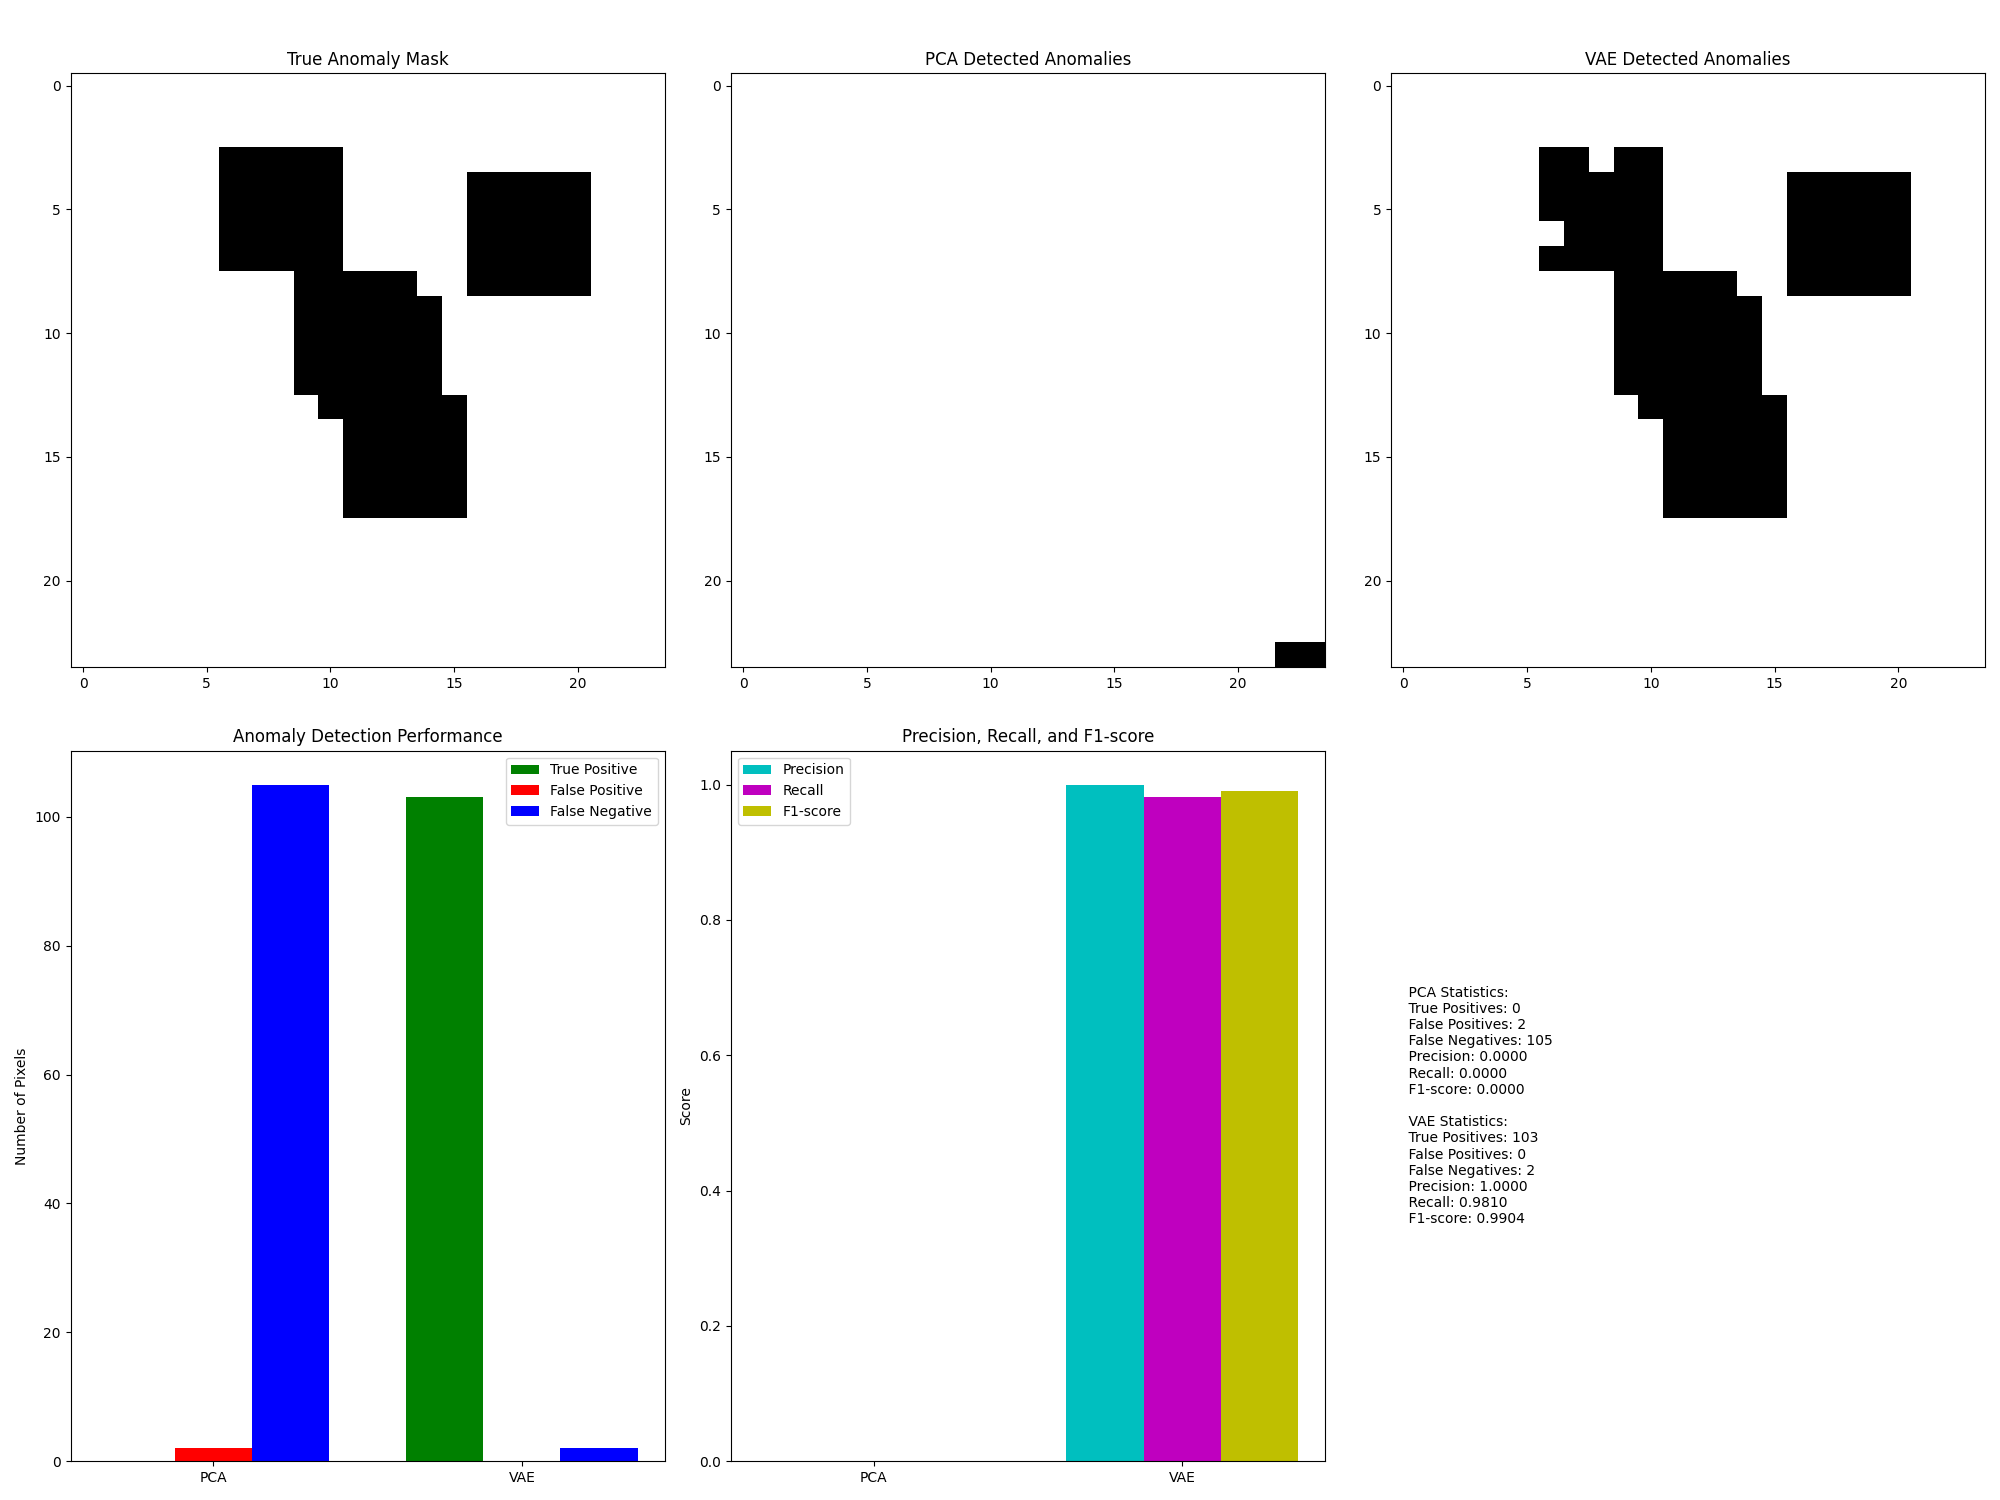

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.decomposition import PCA

def analyze_anomaly_detection(model, input_data, pcau, sub_image_index, anomaly_mask, threshold=60, device='cuda'):
    """
    Analyze and compare anomaly detection performance of PCA and VAE.
    
    Args:
    model (torch.nn.Module): The trained VAE model
    input_data (numpy.ndarray): The input data (shape: num_sub_images x height x width x energy)
    pcau (sklearn.decomposition.PCA): Fitted PCA object
    sub_image_index (int): Index of the sub-image to analyze
    anomaly_mask (numpy.ndarray): Boolean mask indicating true anomalies
    threshold (float): Threshold for considering a pixel as anomalous
    device (str): The device to run the model on ('cuda' or 'cpu')
    
    Returns:
    None (displays the plot)
    """
    # Select the sub-image
    input_sub_image = input_data[sub_image_index]

    # Perform PCA
    pca = PCA(n_components=30)
    flattened_data = input_data.reshape(input_data.shape[0], -1)
    pca_result = pca.fit_transform(flattened_data)
    
    # Reconstruct using only the top 5 components
    top_components = pca_result[:, :5]
    reduced_components = pca.components_[:5, :]
    pca_reconstruction = np.dot(top_components, reduced_components) + pca.mean_
    pca_reconstruction = pca_reconstruction.reshape(input_data.shape)
    pca_sub_image = pca_reconstruction[sub_image_index]

    # Autoencoder reconstruction
    with torch.no_grad():
        input_tensor = torch.tensor(input_sub_image).unsqueeze(0).unsqueeze(0).float().to(device)
        reconstructed, _, _ = model(input_tensor)
        ae_reconstruction = reconstructed.squeeze().cpu().numpy()

    # Calculate reconstruction errors
    pca_error = np.abs(input_sub_image - pca_sub_image)
    ae_error = np.abs(input_sub_image - ae_reconstruction)

    # Calculate error maps (sum along energy axis)
    pca_error_map = np.sum(pca_error, axis=-1)
    ae_error_map = np.sum(ae_error, axis=-1)

    # Create binary masks for detected anomalies
    pca_detected = pca_error_map > threshold
    ae_detected = ae_error_map > threshold

    # Calculate TP, FP, FN for PCA and VAE
    pca_tp = np.sum((pca_detected == 1) & (anomaly_mask == 1))
    pca_fp = np.sum((pca_detected == 1) & (anomaly_mask == 0))
    pca_fn = np.sum((pca_detected == 0) & (anomaly_mask == 1))

    ae_tp = np.sum((ae_detected == 1) & (anomaly_mask == 1))
    ae_fp = np.sum((ae_detected == 1) & (anomaly_mask == 0))
    ae_fn = np.sum((ae_detected == 0) & (anomaly_mask == 1))

    # Calculate precision, recall, and F1-score
    pca_precision = pca_tp / (pca_tp + pca_fp) if (pca_tp + pca_fp) > 0 else 0
    pca_recall = pca_tp / (pca_tp + pca_fn) if (pca_tp + pca_fn) > 0 else 0
    pca_f1 = 2 * (pca_precision * pca_recall) / (pca_precision + pca_recall) if (pca_precision + pca_recall) > 0 else 0

    ae_precision = ae_tp / (ae_tp + ae_fp) if (ae_tp + ae_fp) > 0 else 0
    ae_recall = ae_tp / (ae_tp + ae_fn) if (ae_tp + ae_fn) > 0 else 0
    ae_f1 = 2 * (ae_precision * ae_recall) / (ae_precision + ae_recall) if (ae_precision + ae_recall) > 0 else 0

    # Plotting
    fig, axs = plt.subplots(2, 3, figsize=(20, 15))
    plt.subplots_adjust(wspace=0.3, hspace=0.3)

    # True anomaly mask
    axs[0, 0].imshow(anomaly_mask, cmap='binary')
    axs[0, 0].set_title("True Anomaly Mask")

    # PCA detected anomalies
    axs[0, 1].imshow(pca_detected, cmap='binary')
    axs[0, 1].set_title("PCA Detected Anomalies")

    # VAE detected anomalies
    axs[0, 2].imshow(ae_detected, cmap='binary')
    axs[0, 2].set_title("VAE Detected Anomalies")

    # Bar plot for TP, FP, FN
    methods = ['PCA', 'VAE']
    tp = [pca_tp, ae_tp]
    fp = [pca_fp, ae_fp]
    fn = [pca_fn, ae_fn]

    x = np.arange(len(methods))
    width = 0.25

    axs[1, 0].bar(x - width, tp, width, label='True Positive', color='g')
    axs[1, 0].bar(x, fp, width, label='False Positive', color='r')
    axs[1, 0].bar(x + width, fn, width, label='False Negative', color='b')

    axs[1, 0].set_ylabel('Number of Pixels')
    axs[1, 0].set_title('Anomaly Detection Performance')
    axs[1, 0].set_xticks(x)
    axs[1, 0].set_xticklabels(methods)
    axs[1, 0].legend()

    # Bar plot for Precision, Recall, F1-score
    precision = [pca_precision, ae_precision]
    recall = [pca_recall, ae_recall]
    f1 = [pca_f1, ae_f1]

    axs[1, 1].bar(x - width, precision, width, label='Precision', color='c')
    axs[1, 1].bar(x, recall, width, label='Recall', color='m')
    axs[1, 1].bar(x + width, f1, width, label='F1-score', color='y')

    axs[1, 1].set_ylabel('Score')
    axs[1, 1].set_title('Precision, Recall, and F1-score')
    axs[1, 1].set_xticks(x)
    axs[1, 1].set_xticklabels(methods)
    axs[1, 1].legend()

    # Print statistics
    stats_text = f"""
    PCA Statistics:
    True Positives: {pca_tp}
    False Positives: {pca_fp}
    False Negatives: {pca_fn}
    Precision: {pca_precision:.4f}
    Recall: {pca_recall:.4f}
    F1-score: {pca_f1:.4f}

    VAE Statistics:
    True Positives: {ae_tp}
    False Positives: {ae_fp}
    False Negatives: {ae_fn}
    Precision: {ae_precision:.4f}
    Recall: {ae_recall:.4f}
    F1-score: {ae_f1:.4f}
    """
    axs[1, 2].text(0, 0.5, stats_text, va='center', ha='left', fontsize=10)
    axs[1, 2].axis('off')

    plt.tight_layout()
    plt.show()

# Usage example:
analyze_anomaly_detection(model, modified_anomalous_data, pca, sub_image_index=19, anomaly_mask=anomaly_mask, threshold=65, device="cuda")

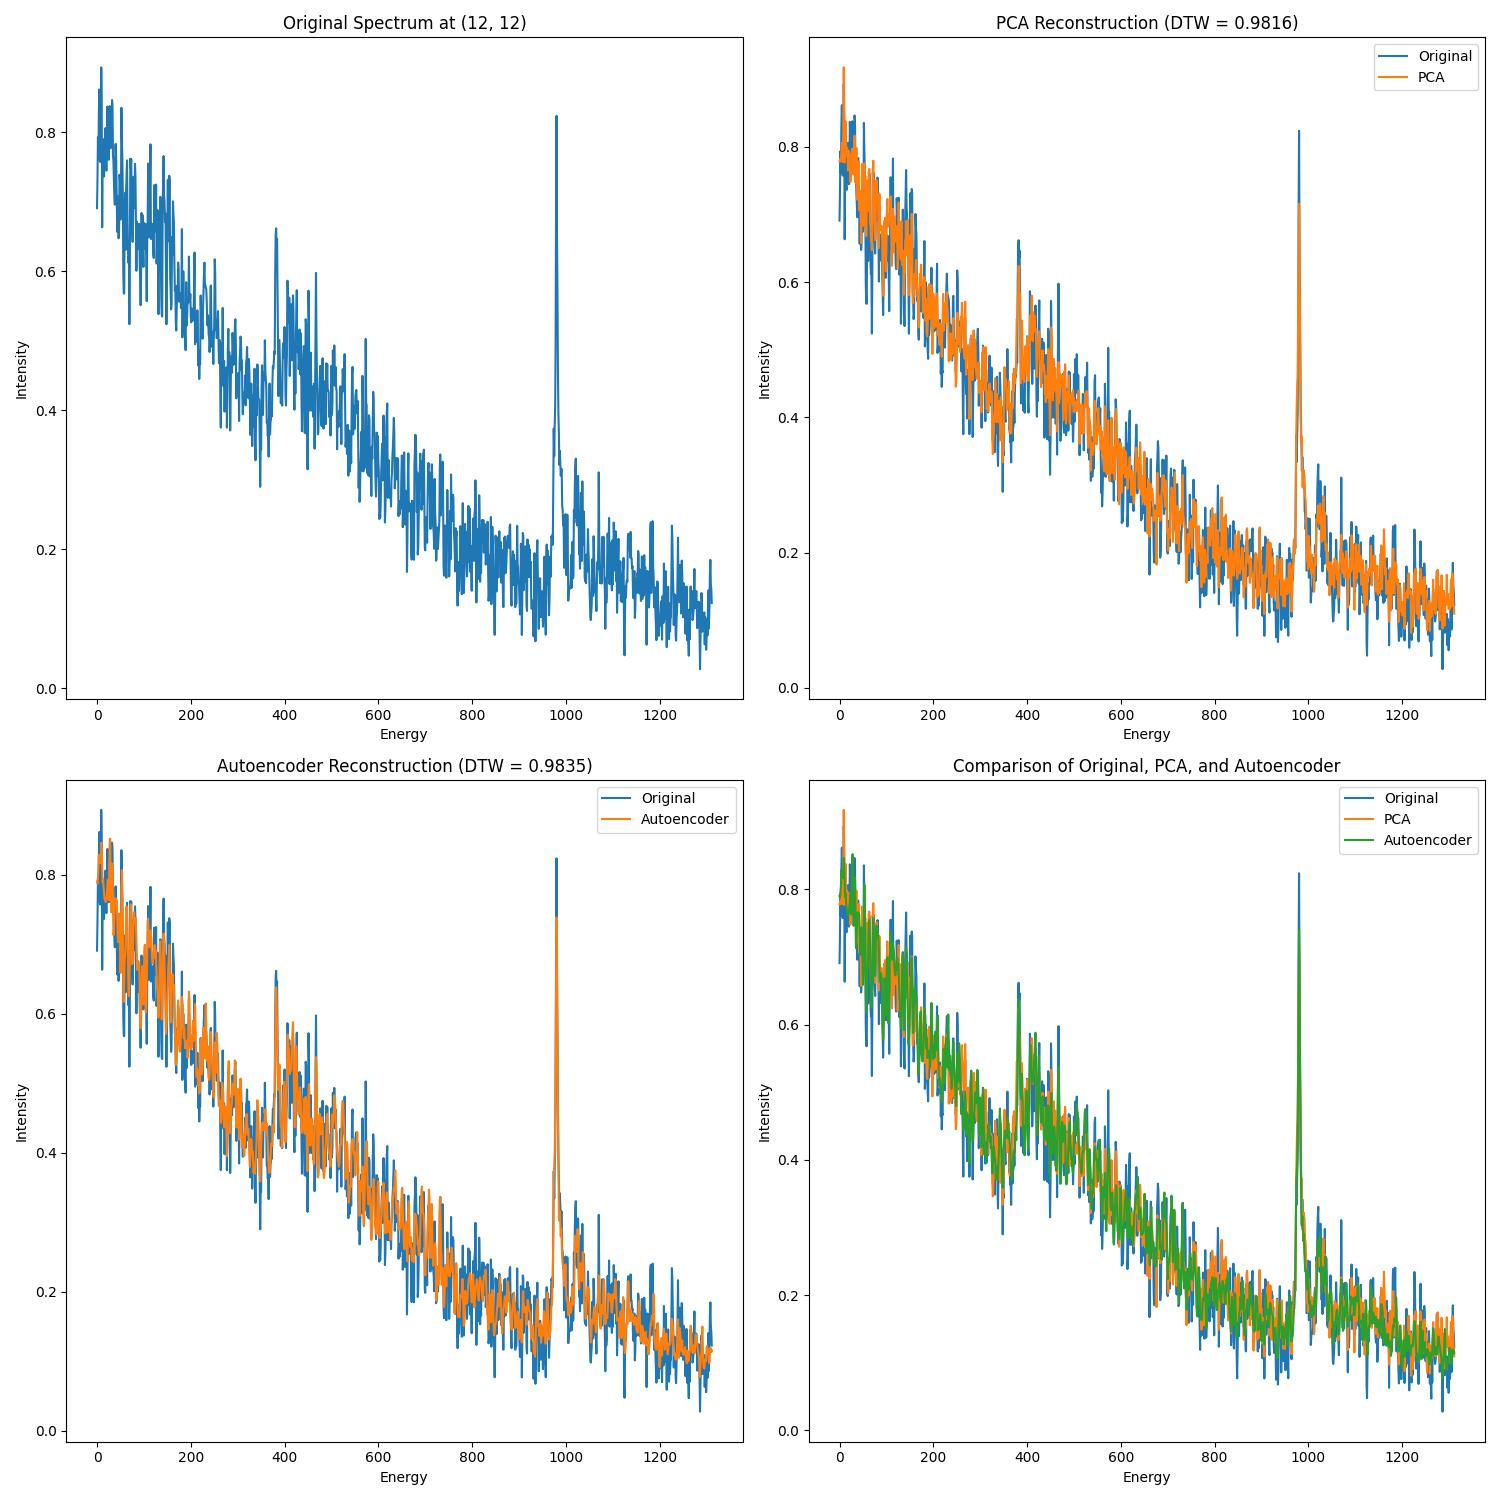

PCA DTW Error: 0.9816
Autoencoder DTW Error: 0.9835


In [9]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.decomposition import PCA
from dtaidistance import dtw

def compare_reconstruction_errors(model, input_data, pca, sub_image_index, coordinate=(12, 12), device='cuda'):
    """
    Compare reconstruction errors between PCA and Autoencoder using DTW similarity for a single spectrum.
    Args:
    model (torch.nn.Module): The trained VAE model
    input_data (numpy.ndarray): The input data (shape: num_sub_images x height x width x energy)
    pca (sklearn.decomposition.PCA): Fitted PCA object
    sub_image_index (int): Index of the sub-image to visualize
    coordinate (tuple): The (x, y) coordinate of the spectrum to analyze
    device (str): The device to run the model on ('cuda' or 'cpu')
    Returns:
    None (displays the plot)
    """
    # Select the sub-image
    input_sub_image = input_data[sub_image_index]

    # Extract the spectrum at the given coordinate
    x, y = coordinate
    original_spectrum = input_sub_image[x, y]

    # PCA reconstruction
    flattened_sub_image = input_sub_image.reshape(1, -1)
    pca_reconstruction = pca.inverse_transform(pca.transform(flattened_sub_image))
    pca_reconstruction = pca_reconstruction.reshape(input_sub_image.shape)
    pca_spectrum = pca_reconstruction[x, y]

    # Autoencoder reconstruction
    with torch.no_grad():
        input_tensor = torch.tensor(input_sub_image).unsqueeze(0).unsqueeze(0).float().to(device)
        reconstructed, _, _ = model(input_tensor)
        ae_reconstruction = reconstructed.squeeze().cpu().numpy()
    ae_spectrum = ae_reconstruction[x, y]

    # Calculate reconstruction errors using DTW
    pca_error = dtw.distance(original_spectrum, pca_spectrum)
    ae_error = dtw.distance(original_spectrum, ae_spectrum)

    # Plotting
    fig, axs = plt.subplots(2, 2, figsize=(15, 15))
    plt.subplots_adjust(wspace=0.3, hspace=0.3)

    # Original spectrum
    axs[0, 0].plot(original_spectrum)
    axs[0, 0].set_title(f"Original Spectrum at {coordinate}")
    axs[0, 0].set_xlabel("Energy")
    axs[0, 0].set_ylabel("Intensity")

    # PCA reconstruction
    axs[0, 1].plot(original_spectrum, label="Original")
    axs[0, 1].plot(pca_spectrum, label="PCA")
    axs[0, 1].set_title(f"PCA Reconstruction (DTW = {pca_error:.4f})")
    axs[0, 1].set_xlabel("Energy")
    axs[0, 1].set_ylabel("Intensity")
    axs[0, 1].legend()

    # Autoencoder reconstruction
    axs[1, 0].plot(original_spectrum, label="Original")
    axs[1, 0].plot(ae_spectrum, label="Autoencoder")
    axs[1, 0].set_title(f"Autoencoder Reconstruction (DTW = {ae_error:.4f})")
    axs[1, 0].set_xlabel("Energy")
    axs[1, 0].set_ylabel("Intensity")
    axs[1, 0].legend()

    # Comparison of all three
    axs[1, 1].plot(original_spectrum, label="Original")
    axs[1, 1].plot(pca_spectrum, label="PCA")
    axs[1, 1].plot(ae_spectrum, label="Autoencoder")
    axs[1, 1].set_title("Comparison of Original, PCA, and Autoencoder")
    axs[1, 1].set_xlabel("Energy")
    axs[1, 1].set_ylabel("Intensity")
    axs[1, 1].legend()

    plt.tight_layout()
    plt.show()

    # Print statistics
    print(f"PCA DTW Error: {pca_error:.4f}")
    print(f"Autoencoder DTW Error: {ae_error:.4f}")

# Usage example:
compare_reconstruction_errors(model, modified_anomalous_data, pca, sub_image_index=18, coordinate=(12, 12), device="cuda")

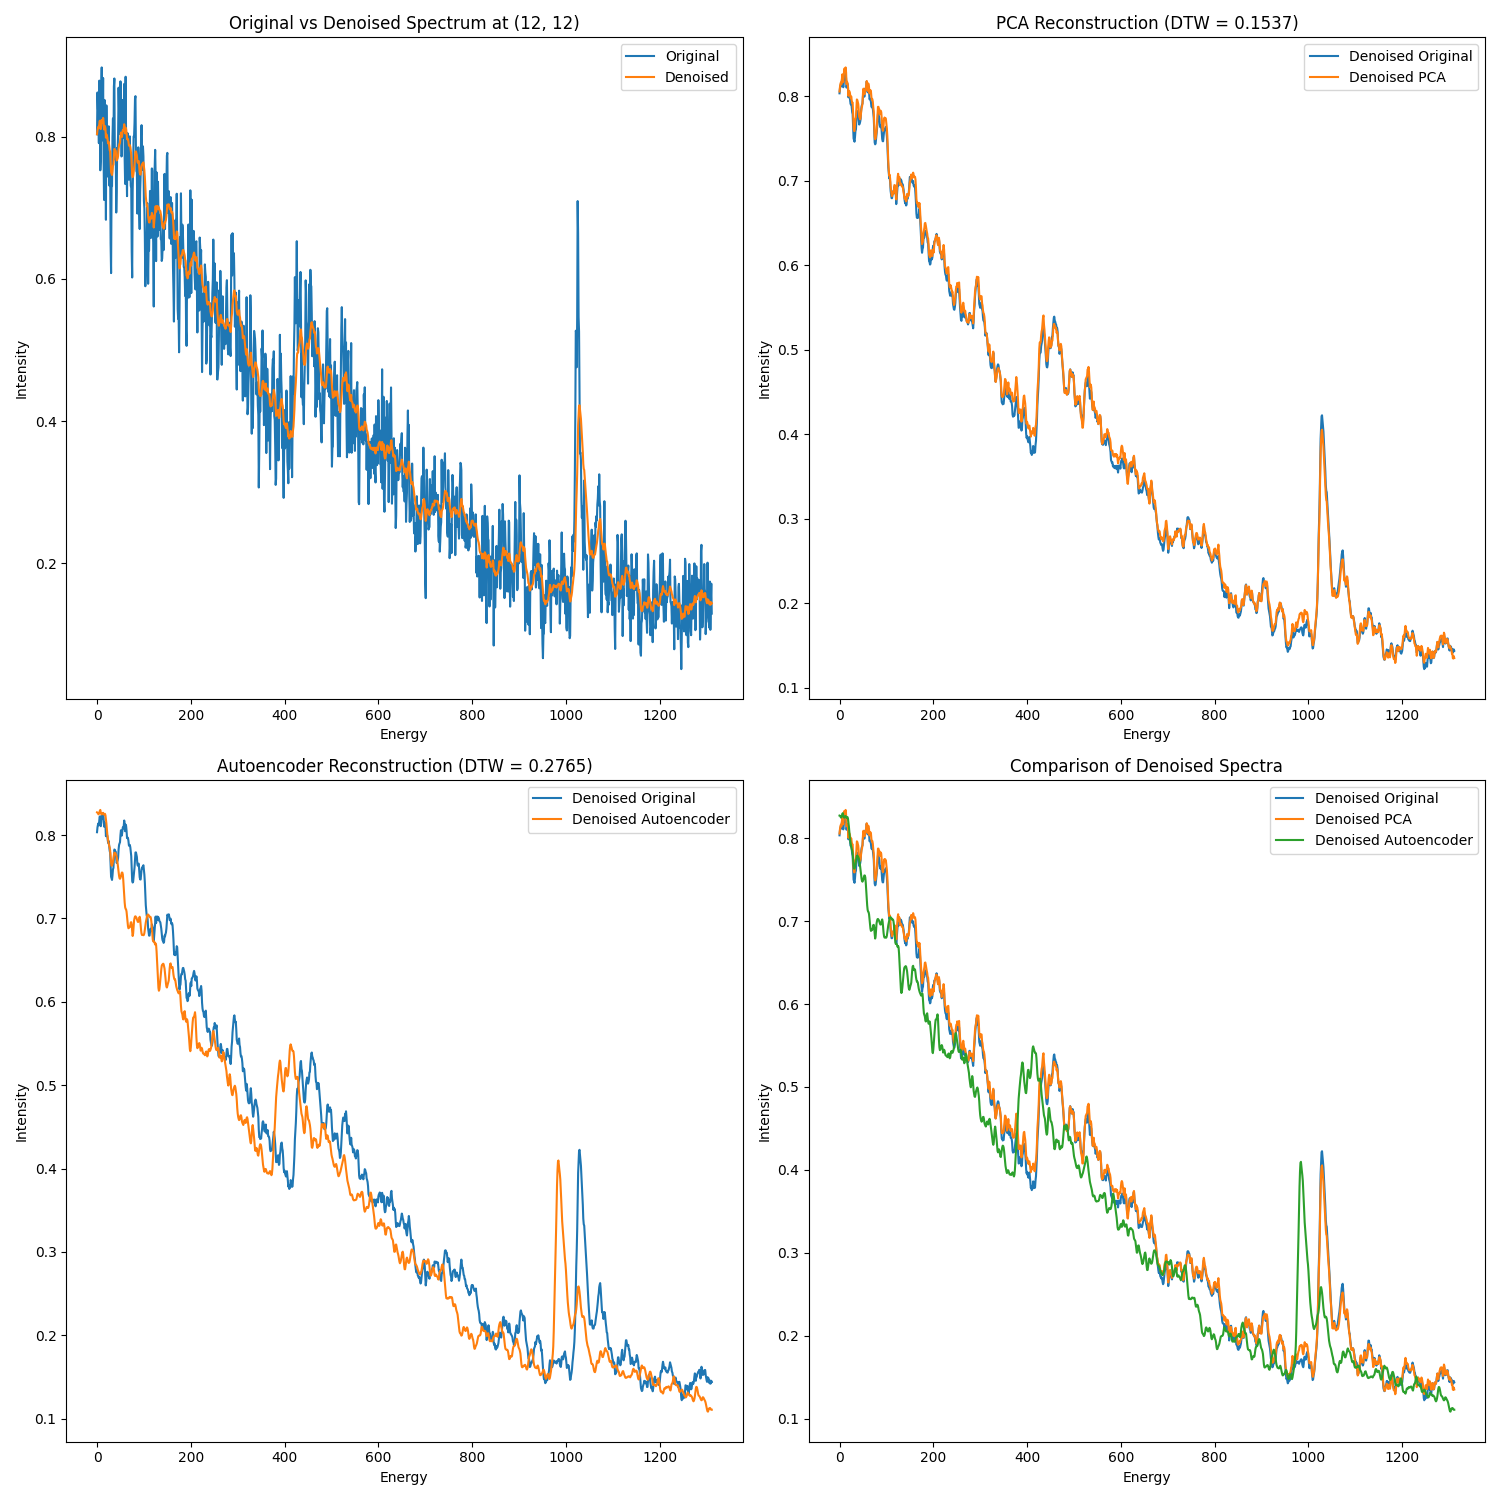

PCA DTW Error (on denoised spectra): 0.1537
Autoencoder DTW Error (on denoised spectra): 0.2765


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.decomposition import PCA
from dtaidistance import dtw

def ema_denoise(data, alpha=0.1):
    """
    Apply Exponential Moving Average (EMA) to denoise the data.
    
    Args:
    data (np.array): Input data to denoise
    alpha (float): Smoothing factor (0 < alpha <= 1)
    
    Returns:
    np.array: Denoised data
    """
    ema = np.zeros_like(data)
    ema[0] = data[0]
    for i in range(1, len(data)):
        ema[i] = alpha * data[i] + (1 - alpha) * ema[i-1]
    return ema

def compare_reconstruction_errors(model, input_data, pca, sub_image_index, coordinate=(12, 12), device='cuda', ema_alpha=0.3):
    """
    Compare reconstruction errors between PCA and Autoencoder using DTW similarity for a single spectrum,
    with EMA denoising applied before comparison.
    
    Args:
    model (torch.nn.Module): The trained VAE model
    input_data (numpy.ndarray): The input data (shape: num_sub_images x height x width x energy)
    pca (sklearn.decomposition.PCA): Fitted PCA object
    sub_image_index (int): Index of the sub-image to visualize
    coordinate (tuple): The (x, y) coordinate of the spectrum to analyze
    device (str): The device to run the model on ('cuda' or 'cpu')
    ema_alpha (float): Smoothing factor for EMA denoising
    
    Returns:
    None (displays the plot)
    """
    # Select the sub-image
    input_sub_image = input_data[sub_image_index]

    # Extract the spectrum at the given coordinate
    x, y = coordinate
    original_spectrum = input_sub_image[x, y]

    # Apply EMA denoising
    denoised_spectrum = ema_denoise(original_spectrum, alpha=ema_alpha)

    # PCA reconstruction
    flattened_sub_image = input_sub_image.reshape(1, -1)
    pca_reconstruction = pca.inverse_transform(pca.transform(flattened_sub_image))
    pca_reconstruction = pca_reconstruction.reshape(input_sub_image.shape)
    pca_spectrum = pca_reconstruction[x, y]
    denoised_pca_spectrum = ema_denoise(pca_spectrum, alpha=ema_alpha)

    # Autoencoder reconstruction
    with torch.no_grad():
        input_tensor = torch.tensor(input_sub_image).unsqueeze(0).unsqueeze(0).float().to(device)
        reconstructed, _, _ = model(input_tensor)
        ae_reconstruction = reconstructed.squeeze().cpu().numpy()
    ae_spectrum = ae_reconstruction[x, y]
    denoised_ae_spectrum = ema_denoise(ae_spectrum, alpha=ema_alpha)

    # Calculate reconstruction errors using DTW on denoised spectra
    pca_error = dtw.distance(denoised_spectrum, denoised_pca_spectrum)
    ae_error = dtw.distance(denoised_spectrum, denoised_ae_spectrum)

    # Plotting
    fig, axs = plt.subplots(2, 2, figsize=(15, 15))
    plt.subplots_adjust(wspace=0.3, hspace=0.3)

    # Original and denoised spectrum
    axs[0, 0].plot(original_spectrum, label="Original")
    axs[0, 0].plot(denoised_spectrum, label="Denoised")
    axs[0, 0].set_title(f"Original vs Denoised Spectrum at {coordinate}")
    axs[0, 0].set_xlabel("Energy")
    axs[0, 0].set_ylabel("Intensity")
    axs[0, 0].legend()

    # PCA reconstruction
    axs[0, 1].plot(denoised_spectrum, label="Denoised Original")
    axs[0, 1].plot(denoised_pca_spectrum, label="Denoised PCA")
    axs[0, 1].set_title(f"PCA Reconstruction (DTW = {pca_error:.4f})")
    axs[0, 1].set_xlabel("Energy")
    axs[0, 1].set_ylabel("Intensity")
    axs[0, 1].legend()

    # Autoencoder reconstruction
    axs[1, 0].plot(denoised_spectrum, label="Denoised Original")
    axs[1, 0].plot(denoised_ae_spectrum, label="Denoised Autoencoder")
    axs[1, 0].set_title(f"Autoencoder Reconstruction (DTW = {ae_error:.4f})")
    axs[1, 0].set_xlabel("Energy")
    axs[1, 0].set_ylabel("Intensity")
    axs[1, 0].legend()

    # Comparison of all three denoised spectra
    axs[1, 1].plot(denoised_spectrum, label="Denoised Original")
    axs[1, 1].plot(denoised_pca_spectrum, label="Denoised PCA")
    axs[1, 1].plot(denoised_ae_spectrum, label="Denoised Autoencoder")
    axs[1, 1].set_title("Comparison of Denoised Spectra")
    axs[1, 1].set_xlabel("Energy")
    axs[1, 1].set_ylabel("Intensity")
    axs[1, 1].legend()

    plt.tight_layout()
    plt.show()

    # Print statistics
    print(f"PCA DTW Error (on denoised spectra): {pca_error:.4f}")
    print(f"Autoencoder DTW Error (on denoised spectra): {ae_error:.4f}")

# Usage example:
compare_reconstruction_errors(model, modified_anomalous_data, pca, sub_image_index=19, coordinate=(12, 12), device="cuda", ema_alpha=0.1)

VAE Score: 0.169933 (Anomaly: 0.00%)
PCA Score: 0.143466 (Anomaly: 0.00%)
The PCA method performed better (lower score is better).


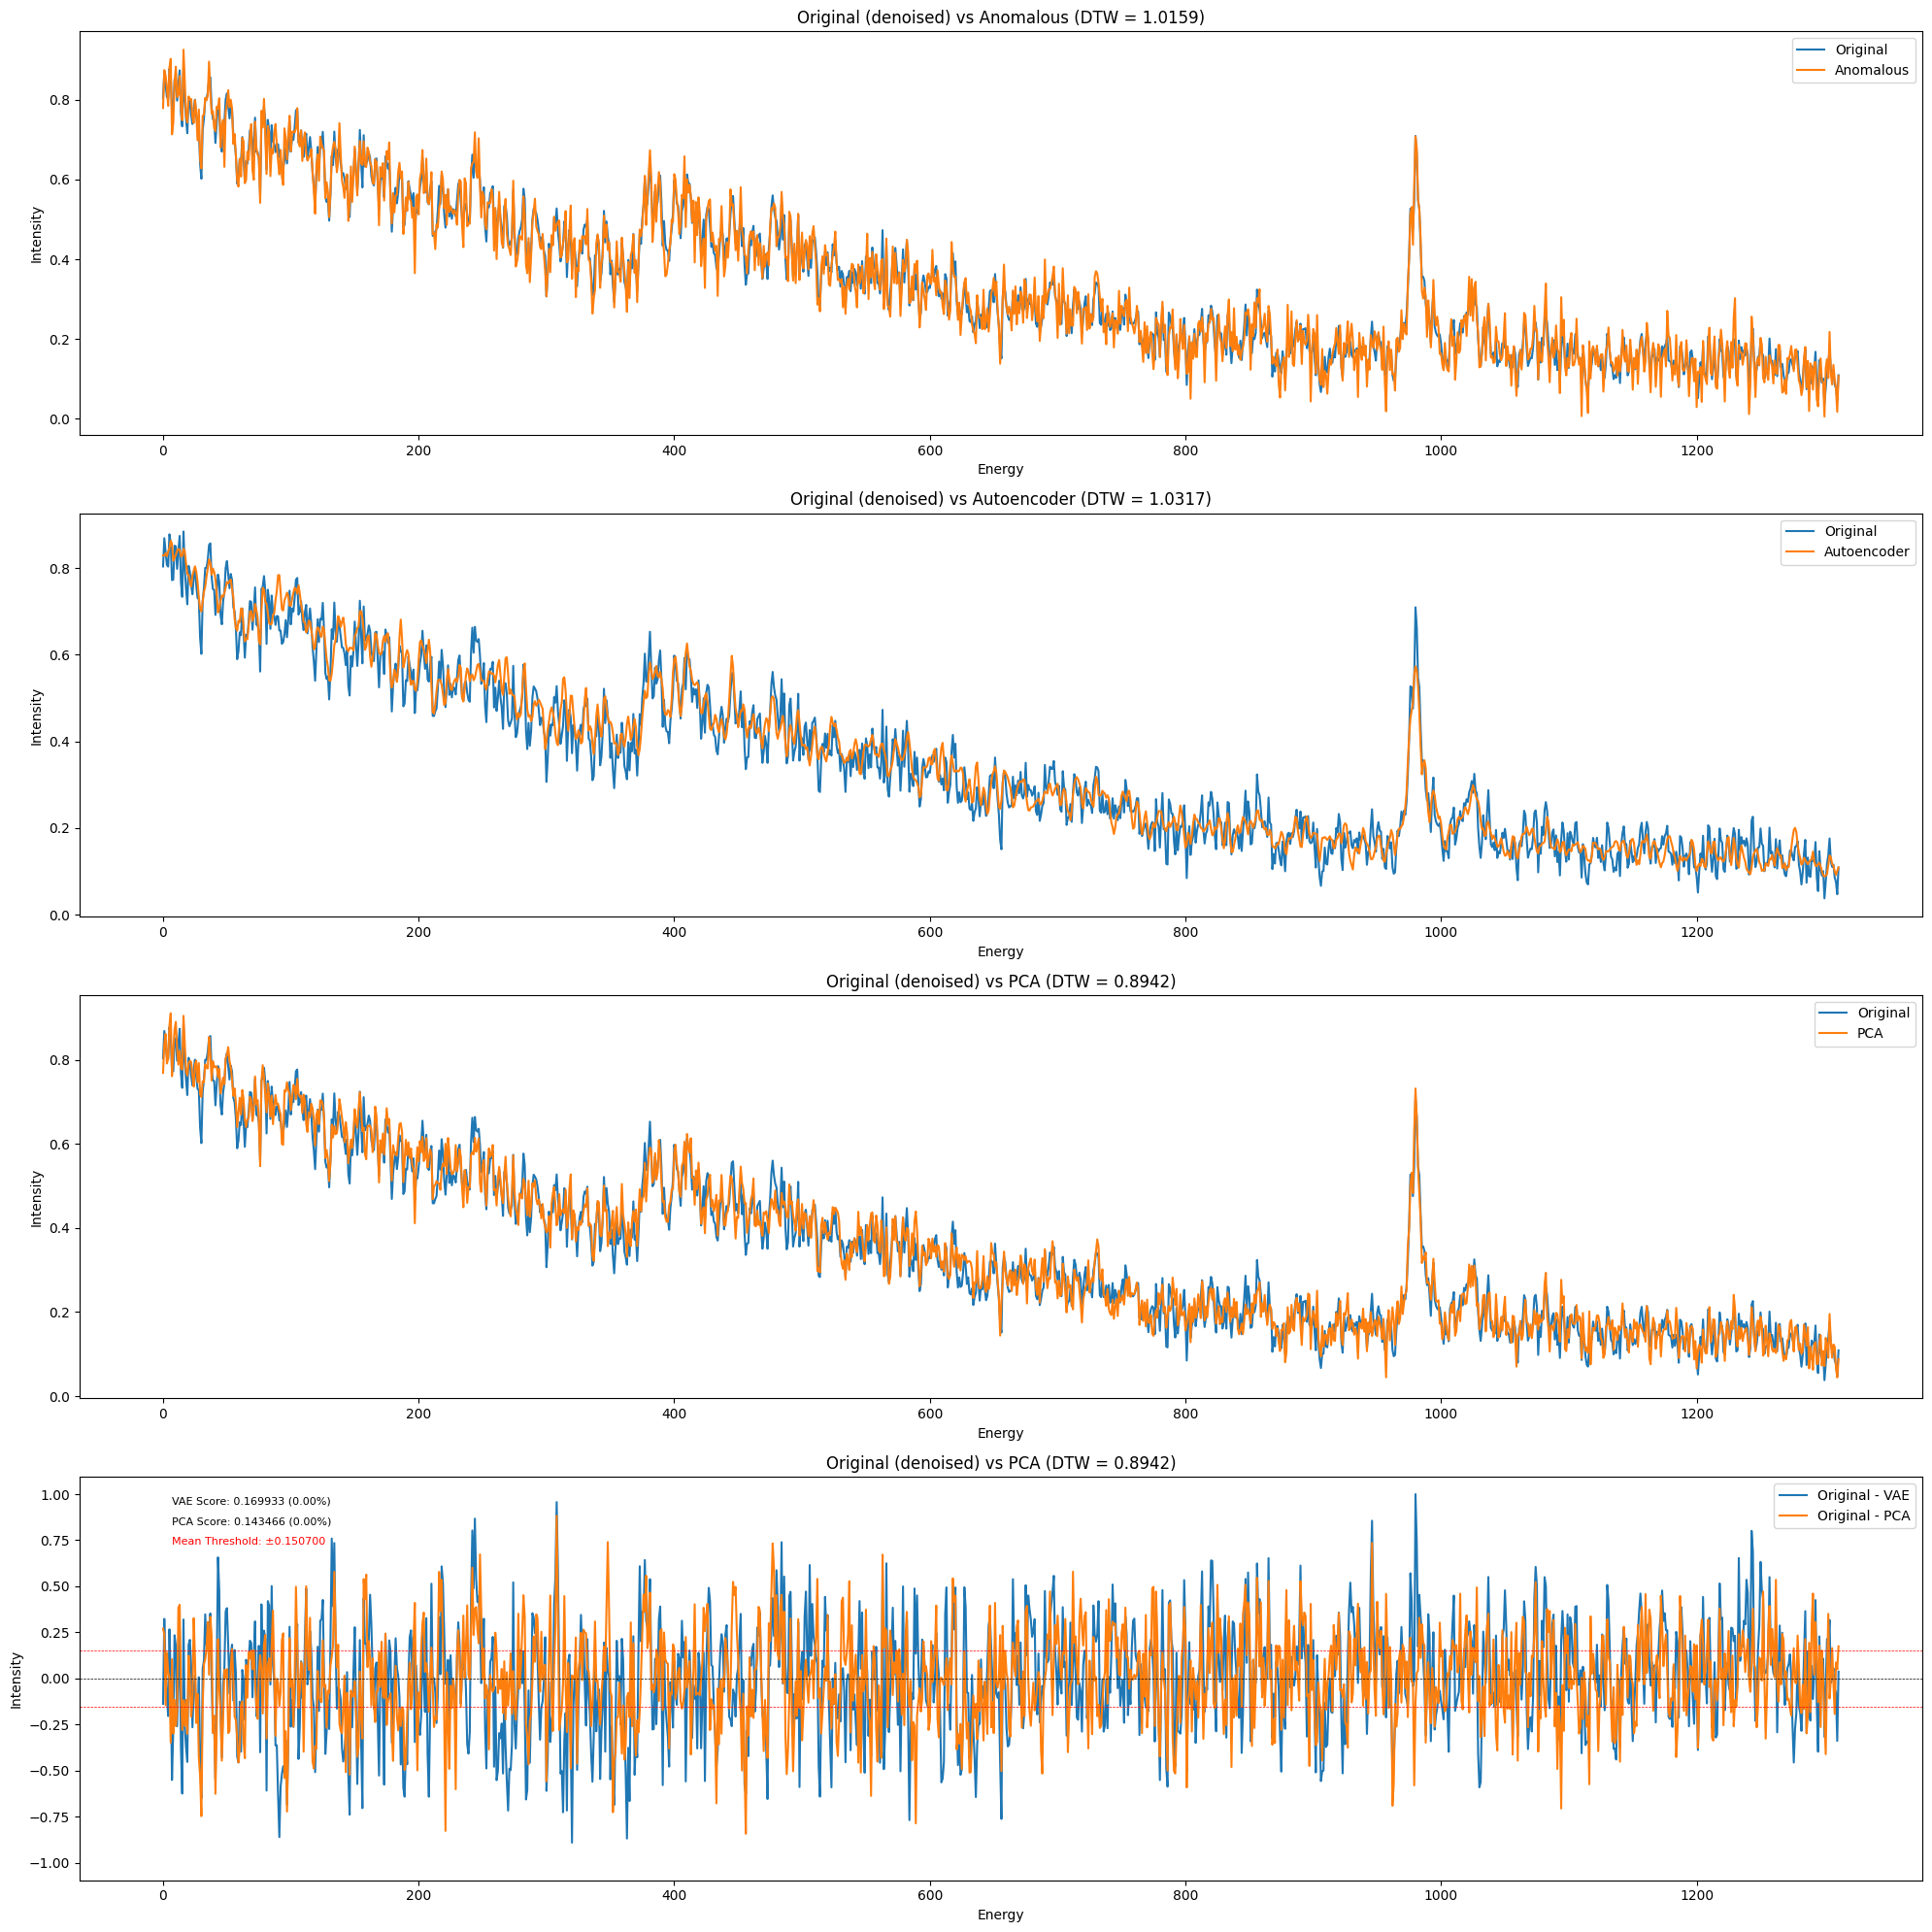

DTW distance (Original vs Anomalous): 1.0159
DTW distance (Original vs Autoencoder): 1.0317
DTW distance (Original vs PCA): 0.8942


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.decomposition import PCA
from dtaidistance import dtw

def inject_anomalies(image, num_clusters=5, cluster_size=4, shift_amount=15, noise_factor=0.09, peak_reduction_factor=0.1, peak_reduction_probability=0):
    """
    Inject anomalies into the EELS image with added noise and peak reduction options.
    
    Args:
    image (numpy.ndarray): Input image of shape (height, width, energy_channels)
    num_clusters (int): Number of anomalous clusters to inject
    cluster_size (int): Size of each anomalous cluster
    shift_amount (int): Amount to shift the peak (in energy channels)
    noise_factor (float): Factor to control the amount of noise added (0 to 1)
    peak_reduction_factor (float): Factor to reduce peak intensity (0 to 1)
    peak_reduction_probability (float): Probability of applying peak reduction to a cluster (0 to 1)
    
    Returns:
    tuple: (anomalous_image, anomaly_mask)
        anomalous_image (numpy.ndarray): Image with injected anomalies, noise, and peak reductions
        anomaly_mask (numpy.ndarray): Boolean mask indicating anomalous pixels
    """
    anomalous_image = np.copy(image)
    height, width, channels = image.shape
    anomaly_mask = np.zeros((height, width), dtype=bool)
    
    # Add global noise
    noise = np.random.normal(0, noise_factor * np.mean(image), image.shape)
    anomalous_image += noise
    
    for _ in range(num_clusters):
        # Choose a random center for the cluster
        center_y = np.random.randint(cluster_size, height - cluster_size)
        center_x = np.random.randint(cluster_size, width - cluster_size)
        
        # Define the cluster region
        y_start, y_end = center_y - cluster_size // 2, center_y + cluster_size // 2 + 1
        x_start, x_end = center_x - cluster_size // 2, center_x + cluster_size // 2 + 1
        
        # Mark the cluster region as anomalous
        anomaly_mask[y_start:y_end, x_start:x_end] = True
        
        # Shift the peak
        if np.random.random() < 0.5:  # 50% chance to shift left or right
            anomalous_image[y_start:y_end, x_start:x_end, :-shift_amount] = image[y_start:y_end, x_start:x_end, shift_amount:]
        else:
            anomalous_image[y_start:y_end, x_start:x_end, shift_amount:] = image[y_start:y_end, x_start:x_end, :-shift_amount]
        
        # Randomly reduce peak intensity
        if np.random.random() < peak_reduction_probability:
            peak_intensity = np.max(anomalous_image[y_start:y_end, x_start:x_end])
            reduction_amount = peak_intensity * peak_reduction_factor
            anomalous_image[y_start:y_end, x_start:x_end] -= reduction_amount
    
    # Ensure all values are non-negative
    anomalous_image = np.clip(anomalous_image, 0, None)
    
    return anomalous_image, anomaly_mask

def compare_spectra(model, input_data, sub_image_index, coordinate=(12, 12), device='cuda', n_pca_fit=30, n_pca_reconstruct=5):
    """
    Compare original, anomalous, and reconstructed spectra using DTW.
    
    Args:
    model (torch.nn.Module): The trained VAE model
    input_data (numpy.ndarray): The input data (shape: num_sub_images x height x width x energy)
    sub_image_index (int): Index of the sub-image to visualize
    coordinate (tuple): The (x, y) coordinate of the spectrum to analyze
    device (str): The device to run the model on ('cuda' or 'cpu')
    n_pca_fit (int): Number of PCA components to fit
    n_pca_reconstruct (int): Number of PCA components to use for reconstruction
    
    Returns:
    None (displays the plot)
    """
    # Select the sub-image and inject anomalies
    input_sub_image = input_data[sub_image_index]
    anomalous_sub_image, _ = inject_anomalies(input_sub_image)
    
    # Create a modified version of input_data with the anomalous sub-image
    modified_input_data = input_data.copy()
    modified_input_data[sub_image_index] = anomalous_sub_image
    
    # Extract the spectrum at the given coordinate
    x, y = coordinate
    original_spectrum = input_sub_image[x, y]
    anomalous_spectrum = anomalous_sub_image[x, y]
    
    # Generate VAE prediction for anomalous data
    with torch.no_grad():
        anomalous_tensor = torch.tensor(anomalous_sub_image).unsqueeze(0).unsqueeze(0).float().to(device)
        mean, logvar = model.encode(anomalous_tensor)
        z = model.reparameterize(mean, logvar)
        prediction_sub_image = model.decode(z).squeeze().cpu().numpy()
    ae_spectrum = prediction_sub_image[x, y]
    
    # Perform PCA
    pca = PCA(n_components=n_pca_fit)
    flattened_data = modified_input_data.reshape(modified_input_data.shape[0], -1)
    pca_result = pca.fit_transform(flattened_data)
    
    # Reconstruct using only the top n_pca_reconstruct components
    top_components = pca_result[:, :n_pca_reconstruct]
    reduced_components = pca.components_[:n_pca_reconstruct, :]
    pca_reconstruction = np.dot(top_components, reduced_components) + pca.mean_
    pca_reconstruction = pca_reconstruction.reshape(modified_input_data.shape)
    pca_spectrum = pca_reconstruction[sub_image_index, x, y]

    # Apply EMA denoising
    # denoised_spectrum = ema_denoise(original_spectrum, alpha=0.3)
    denoised_spectrum = original_spectrum

    # Calculate DTW distances
    dtw_anomalous = dtw.distance(denoised_spectrum, anomalous_spectrum)
    dtw_ae = dtw.distance(denoised_spectrum, ae_spectrum)
    dtw_pca = dtw.distance(denoised_spectrum, pca_spectrum)
    
    # Plotting
    fig, axs = plt.subplots(4, 1, figsize=(20, 20))
    plt.subplots_adjust(wspace=0.3)
    
    # Original vs Anomalous
    axs[0].plot(denoised_spectrum, label="Original")
    axs[0].plot(anomalous_spectrum, label="Anomalous")
    axs[0].set_title(f"Original (denoised) vs Anomalous (DTW = {dtw_anomalous:.4f})")
    axs[0].set_xlabel("Energy")
    axs[0].set_ylabel("Intensity")
    axs[0].legend()
    
    # Original vs Autoencoder
    axs[1].plot(denoised_spectrum, label="Original")
    axs[1].plot(ae_spectrum, label="Autoencoder")
    axs[1].set_title(f"Original (denoised) vs Autoencoder (DTW = {dtw_ae:.4f})")
    axs[1].set_xlabel("Energy")
    axs[1].set_ylabel("Intensity")
    axs[1].legend()
    
    # Original vs PCA
    axs[2].plot(denoised_spectrum, label="Original")
    axs[2].plot(pca_spectrum, label="PCA")
    axs[2].set_title(f"Original (denoised) vs PCA (DTW = {dtw_pca:.4f})")
    axs[2].set_xlabel("Energy")
    axs[2].set_ylabel("Intensity")
    axs[2].legend()

    vae_diff = denoised_spectrum - ae_spectrum
    pca_diff = denoised_spectrum - pca_spectrum

    # Center each difference around its own mean
    vae_diff_centered = vae_diff - np.mean(vae_diff)
    pca_diff_centered = pca_diff - np.mean(pca_diff)

    # Find the maximum absolute value across both centered differences
    max_abs_val = max(np.abs(vae_diff_centered).max(), np.abs(pca_diff_centered).max())

    # Scale both differences to the range [-1, 1]
    vae_diff_scaled = vae_diff_centered / max_abs_val
    pca_diff_scaled = pca_diff_centered / max_abs_val

    # Plot the scaled differences
    axs[3].plot(vae_diff_scaled, label="Original - VAE")
    axs[3].plot(pca_diff_scaled, label="Original - PCA")
    axs[3].set_title(f"Original (denoised) vs PCA (DTW = {dtw_pca:.4f})")
    axs[3].set_xlabel("Energy")
    axs[3].set_ylabel("Intensity")
    axs[3].legend()

    # Set y-axis limits to ensure symmetry around 0
    y_limit = max(abs(axs[3].get_ylim()[0]), abs(axs[3].get_ylim()[1]))
    axs[3].set_ylim(-y_limit, y_limit)

    # Add a horizontal line at y=0 for reference
    axs[3].axhline(y=0, color='k', linestyle='--', linewidth=0.5)

    def calculate_adaptive_spectrum_score(original_spectrum, diff, window_size=5, base_factor=0.5, adaptive_factor=1.5):
        # Calculate the standard deviation of the original spectrum
        spectrum_std = np.std(original_spectrum)
        
        # Set a base threshold
        base_threshold = base_factor * spectrum_std
        
        # Calculate an adaptive threshold based on the local variability of the difference
        local_std = np.array([np.std(diff[max(0, i-window_size):i+window_size+1]) 
                            for i in range(len(diff))])
        adaptive_threshold = base_threshold + adaptive_factor * local_std
        
        # Create a mask for differences exceeding the adaptive threshold
        anomaly_mask = np.abs(diff) > adaptive_threshold
        
        # Apply the mask to the difference
        thresholded_diff = diff * anomaly_mask
        
        # Calculate basic statistics on the thresholded difference
        mse = np.mean(np.square(thresholded_diff))
        max_deviation = np.max(np.abs(thresholded_diff))
        
        # Calculate rolling standard deviation to detect sharp changes
        rolling_std = np.array([np.std(thresholded_diff[max(0, i-window_size):i+1]) 
                                for i in range(len(thresholded_diff))])
        
        # Penalize large deviations more heavily
        large_deviation_penalty = np.mean(np.power(np.abs(thresholded_diff), 4))
        
        # Penalize sharp changes
        sharpness_penalty = np.mean(np.square(rolling_std))
        
        # Calculate the percentage of points considered anomalous
        anomaly_percentage = np.mean(anomaly_mask) * 100
        
        # Combine the components into a final score
        score = mse + 2 * large_deviation_penalty + sharpness_penalty + max_deviation
        
        # If no anomalies were detected, use a small non-zero score based on the original difference
        if score == 0:
            score = np.mean(np.abs(diff)) / spectrum_std
        
        return score, anomaly_percentage, np.mean(adaptive_threshold)

    # Assuming we have the original spectrum and the differences
    vae_score, vae_anomaly_percent, vae_threshold = calculate_adaptive_spectrum_score(denoised_spectrum, vae_diff)
    pca_score, pca_anomaly_percent, pca_threshold = calculate_adaptive_spectrum_score(denoised_spectrum, pca_diff)

    print(f"VAE Score: {vae_score:.6f} (Anomaly: {vae_anomaly_percent:.2f}%)")
    print(f"PCA Score: {pca_score:.6f} (Anomaly: {pca_anomaly_percent:.2f}%)")

    # Determine which method performed better
    better_method = "VAE" if vae_score < pca_score else "PCA"
    print(f"The {better_method} method performed better (lower score is better).")

    # Plot these scores on your existing graph
    axs[3].text(0.05, 0.95, f"VAE Score: {vae_score:.6f} ({vae_anomaly_percent:.2f}%)", 
                transform=axs[3].transAxes, verticalalignment='top', fontsize=8)
    axs[3].text(0.05, 0.90, f"PCA Score: {pca_score:.6f} ({pca_anomaly_percent:.2f}%)", 
                transform=axs[3].transAxes, verticalalignment='top', fontsize=8)

    # Visualize the mean threshold
    axs[3].axhline(y=vae_threshold, color='r', linestyle='--', linewidth=0.5)
    axs[3].axhline(y=-vae_threshold, color='r', linestyle='--', linewidth=0.5)
    axs[3].text(0.05, 0.85, f"Mean Threshold: ±{vae_threshold:.6f}", transform=axs[3].transAxes, 
                verticalalignment='top', fontsize=8, color='red')
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print(f"DTW distance (Original vs Anomalous): {dtw_anomalous:.4f}")
    print(f"DTW distance (Original vs Autoencoder): {dtw_ae:.4f}")
    print(f"DTW distance (Original vs PCA): {dtw_pca:.4f}")

# Usage example:
compare_spectra(model, dataset, sub_image_index=19, coordinate=(12, 12), device="cuda", n_pca_fit=30, n_pca_reconstruct=4)

/home/ssulta24/miniconda/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


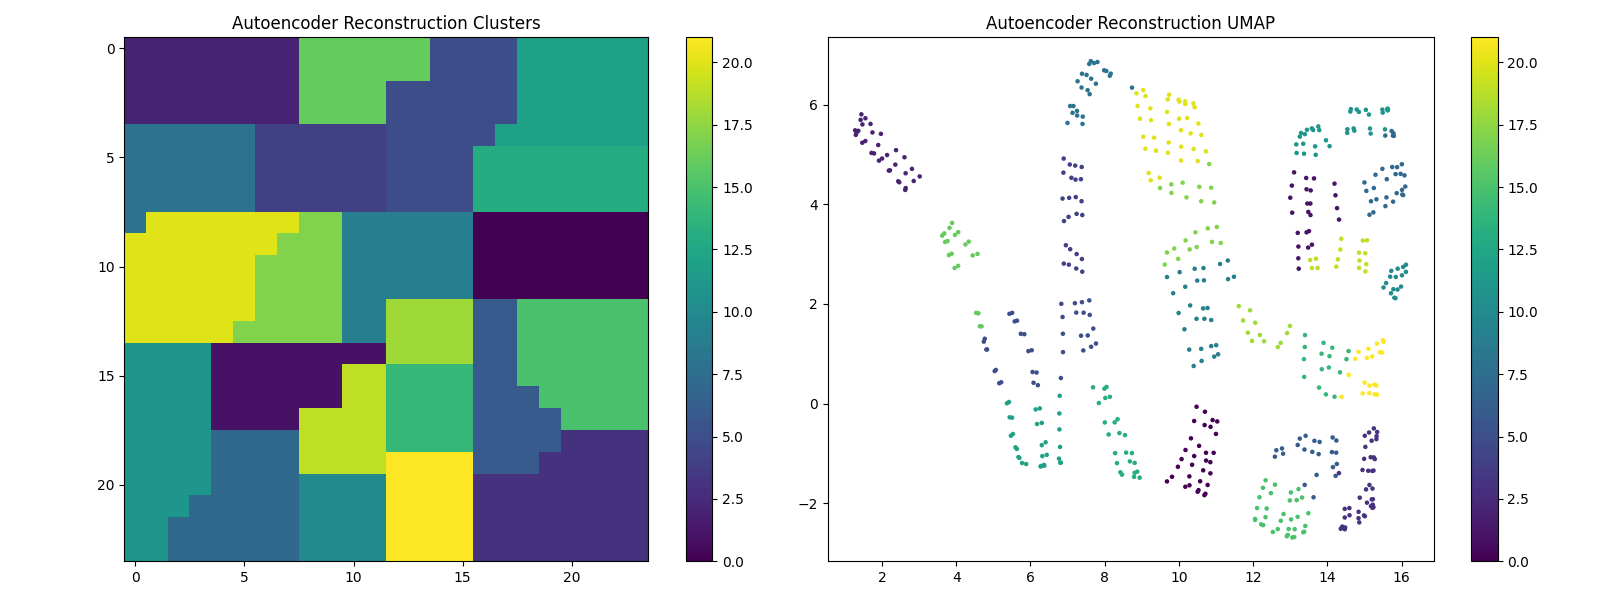


Autoencoder Reconstruction Cluster Distribution:
Cluster 0: 32 pixels (5.56%)
Cluster 1: 24 pixels (4.17%)
Cluster 2: 32 pixels (5.56%)
Cluster 3: 41 pixels (7.12%)
Cluster 4: 24 pixels (4.17%)
Cluster 5: 37 pixels (6.42%)
Cluster 6: 22 pixels (3.82%)
Cluster 7: 29 pixels (5.03%)
Cluster 8: 25 pixels (4.34%)
Cluster 9: 28 pixels (4.86%)
Cluster 10: 16 pixels (2.78%)
Cluster 11: 35 pixels (6.08%)
Cluster 12: 31 pixels (5.38%)
Cluster 13: 24 pixels (4.17%)
Cluster 14: 16 pixels (2.78%)
Cluster 15: 33 pixels (5.73%)
Cluster 16: 20 pixels (3.47%)
Cluster 17: 22 pixels (3.82%)
Cluster 18: 12 pixels (2.08%)
Cluster 19: 16 pixels (2.78%)
Cluster 20: 37 pixels (6.42%)
Cluster 21: 20 pixels (3.47%)


In [21]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.cluster import KMeans
import umap

def cluster_autoencoder_predictions(model, input_data, sub_image_index, n_clusters=6, umap_n_components=2, umap_n_neighbors=15, umap_min_dist=0.1, device='cuda'):
    """
    Perform cluster-based analysis on Autoencoder predictions.
    
    Args:
    model (torch.nn.Module): The trained VAE model
    input_data (numpy.ndarray): The input data (shape: num_sub_images x height x width x energy)
    sub_image_index (int): Index of the sub-image to analyze
    n_clusters (int): Number of clusters for K-means
    umap_n_components (int): Number of dimensions to reduce to with UMAP
    umap_n_neighbors (int): UMAP hyperparameter
    umap_min_dist (float): UMAP hyperparameter
    device (str): The device to run the model on ('cuda' or 'cpu')
    
    Returns:
    None (displays the plots)
    """
    # Select the sub-image
    input_sub_image = input_data[sub_image_index]
    height, width, energy = input_sub_image.shape

    # Autoencoder reconstruction
    with torch.no_grad():
        input_tensor = torch.tensor(input_sub_image).unsqueeze(0).unsqueeze(0).float().to(device)
        reconstructed, _, _ = model(input_tensor)
        ae_reconstruction = reconstructed.squeeze().cpu().numpy()

    # Flatten the reconstructed data
    ae_data = ae_reconstruction.reshape(-1, energy)

    # Apply UMAP for dimensionality reduction
    reducer = umap.UMAP(n_components=umap_n_components, n_neighbors=umap_n_neighbors, min_dist=umap_min_dist, random_state=42)
    ae_umap = reducer.fit_transform(ae_data)

    # Perform K-means clustering on UMAP-reduced data
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    ae_labels = kmeans.fit_predict(ae_umap)

    # Reshape labels to 2D for visualization
    ae_labels_2d = ae_labels.reshape(height, width)

    # Plotting
    fig, axs = plt.subplots(1, 2, figsize=(16, 6))
    plt.subplots_adjust(wspace=0.3)

    # Autoencoder reconstruction clusters
    im_ae = axs[0].imshow(ae_labels_2d, cmap='viridis')
    axs[0].set_title("Autoencoder Reconstruction Clusters")
    plt.colorbar(im_ae, ax=axs[0])

    # UMAP visualization
    scatter = axs[1].scatter(ae_umap[:, 0], ae_umap[:, 1], c=ae_labels, cmap='viridis', s=5)
    axs[1].set_title("Autoencoder Reconstruction UMAP")
    plt.colorbar(scatter, ax=axs[1])

    plt.tight_layout()
    plt.show()

    # Calculate and print cluster distribution
    unique, counts = np.unique(ae_labels, return_counts=True)
    print("\nAutoencoder Reconstruction Cluster Distribution:")
    for cluster, count in zip(unique, counts):
        percentage = count / len(ae_labels) * 100
        print(f"Cluster {cluster}: {count} pixels ({percentage:.2f}%)")

    return ae_labels_2d, ae_umap

# Usage example:
labels_2d, umap_embedding = cluster_autoencoder_predictions(model, modified_anomalous_data, sub_image_index=19, n_clusters=22, umap_n_components=3, umap_n_neighbors=5, umap_min_dist=0.1, device="cuda")

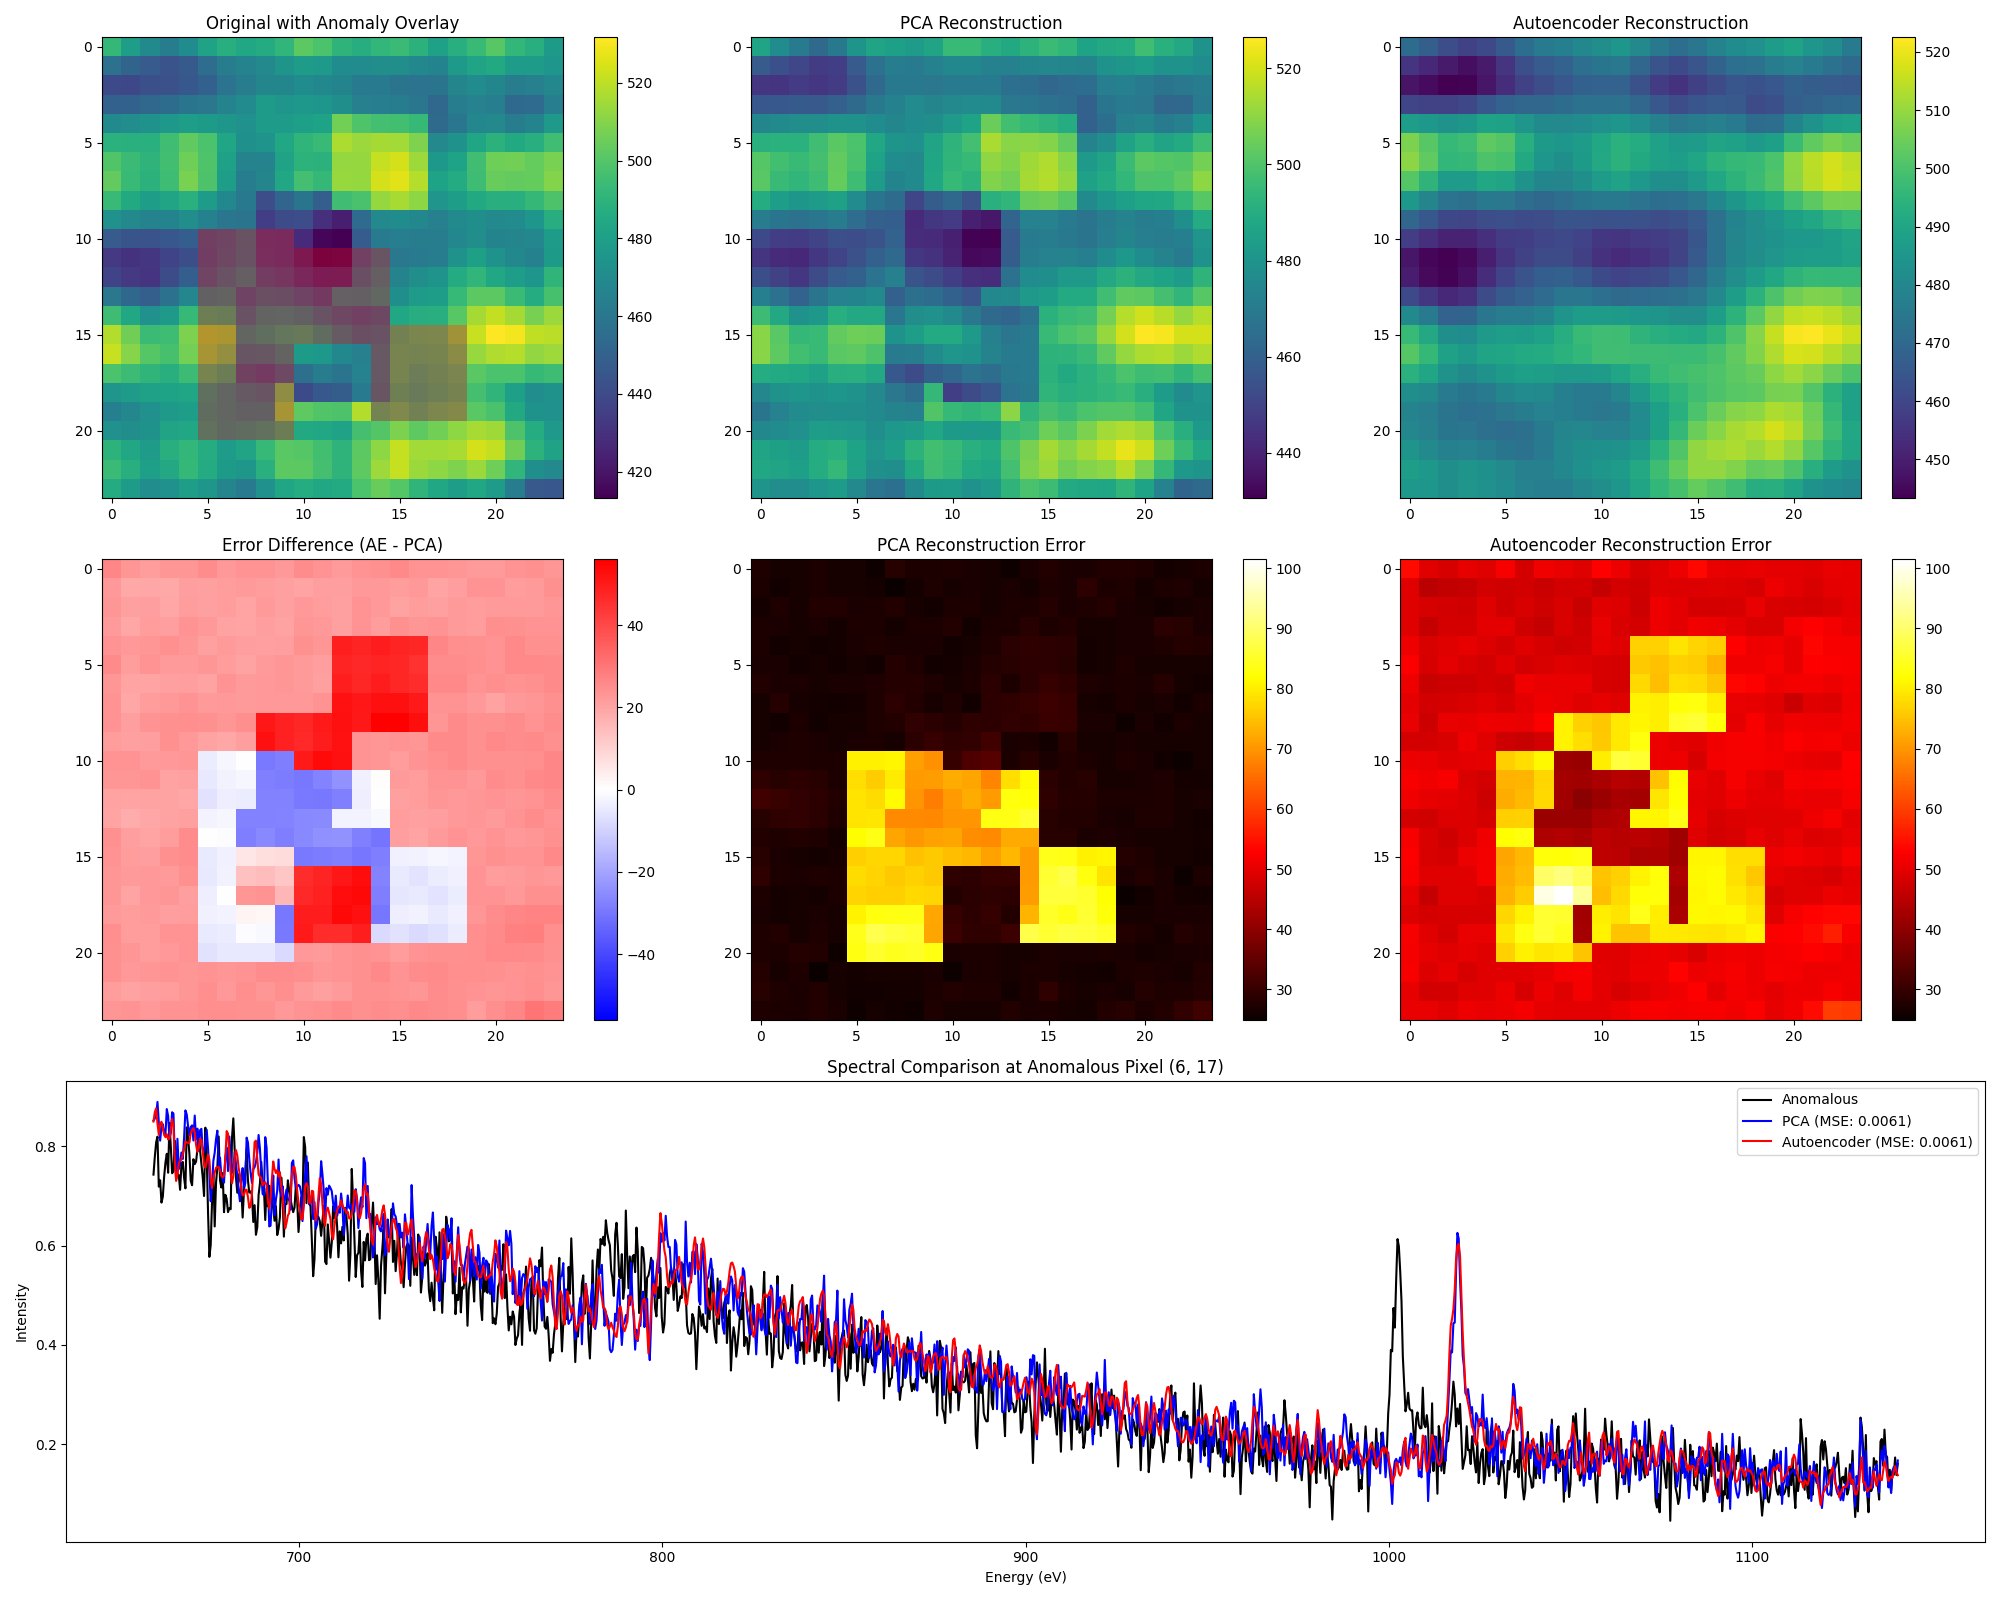

PCA Mean Error: 36.4661
Autoencoder Mean Error: 56.0191
Max PCA Error: 87.7759
Max Autoencoder Error: 101.5106

Spectral Comparison at Pixel (6, 17):
PCA Spectrum MSE: 0.0061
Autoencoder Spectrum MSE: 0.0061


In [10]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.decomposition import PCA
from matplotlib.colors import LinearSegmentedColormap

def compare_reconstruction_errors_with_spectra(model, input_data, pca, sub_image_index, device='cuda', energy_range=(0, 1000)):
    """
    Compare reconstruction errors between PCA and Autoencoder with same scale, anomaly overlay, and spectral comparison.
    
    Args:
    model (torch.nn.Module): The trained VAE model
    input_data (numpy.ndarray): The input data (shape: num_sub_images x height x width x energy)
    pca (sklearn.decomposition.PCA): Fitted PCA object
    sub_image_index (int): Index of the sub-image to visualize
    device (str): The device to run the model on ('cuda' or 'cpu')
    energy_range (tuple): The range of energy values for the spectra
    
    Returns:
    None (displays the plots)
    """
    # Select the sub-image
    input_sub_image = input_data[sub_image_index]
    
    # Inject anomalies
    anomalous_sub_image, anomaly_mask = inject_anomalies(input_sub_image)
    
    # PCA reconstruction
    flattened_sub_image = anomalous_sub_image.reshape(1, -1)
    pca_reconstruction = pca.inverse_transform(pca.transform(flattened_sub_image))
    pca_reconstruction = pca_reconstruction.reshape(input_sub_image.shape)
    
    # Autoencoder reconstruction
    with torch.no_grad():
        input_tensor = torch.tensor(anomalous_sub_image).unsqueeze(0).unsqueeze(0).float().to(device)
        reconstructed, _, _ = model(input_tensor)
        ae_reconstruction = reconstructed.squeeze().cpu().numpy()
    
    # Calculate reconstruction errors
    pca_error = np.abs(anomalous_sub_image - pca_reconstruction)
    ae_error = np.abs(anomalous_sub_image - ae_reconstruction)
    
    # Calculate error maps (sum along energy axis)
    pca_error_map = np.sum(pca_error, axis=-1)
    ae_error_map = np.sum(ae_error, axis=-1)
    
    # Determine common min and max for error maps
    error_min = min(pca_error_map.min(), ae_error_map.min())
    error_max = max(pca_error_map.max(), ae_error_map.max())
    
    # Plotting
    fig = plt.figure(figsize=(20, 16))
    gs = fig.add_gridspec(3, 3)
    
    # Original image with anomaly overlay
    ax_orig = fig.add_subplot(gs[0, 0])
    original_sum = np.sum(input_sub_image, axis=-1)
    im_orig = ax_orig.imshow(original_sum, cmap='viridis')
    # Create a red-tinted overlay for anomalies
    anomaly_overlay = np.zeros((*original_sum.shape, 4))
    anomaly_overlay[anomaly_mask] = [1, 0, 0, 0.3]  # Red with 30% opacity
    ax_orig.imshow(anomaly_overlay)
    ax_orig.set_title("Original with Anomaly Overlay")
    plt.colorbar(im_orig, ax=ax_orig)
    
    # PCA reconstruction
    ax_pca = fig.add_subplot(gs[0, 1])
    im_pca = ax_pca.imshow(np.sum(pca_reconstruction, axis=-1), cmap='viridis')
    ax_pca.set_title("PCA Reconstruction")
    plt.colorbar(im_pca, ax=ax_pca)
    
    # Autoencoder reconstruction
    ax_ae = fig.add_subplot(gs[0, 2])
    im_ae = ax_ae.imshow(np.sum(ae_reconstruction, axis=-1), cmap='viridis')
    ax_ae.set_title("Autoencoder Reconstruction")
    plt.colorbar(im_ae, ax=ax_ae)
    
    # PCA error map
    ax_pca_err = fig.add_subplot(gs[1, 1])
    im_pca_err = ax_pca_err.imshow(pca_error_map, cmap='hot', vmin=error_min, vmax=error_max)
    ax_pca_err.set_title("PCA Reconstruction Error")
    plt.colorbar(im_pca_err, ax=ax_pca_err)
    
    # Autoencoder error map
    ax_ae_err = fig.add_subplot(gs[1, 2])
    im_ae_err = ax_ae_err.imshow(ae_error_map, cmap='hot', vmin=error_min, vmax=error_max)
    ax_ae_err.set_title("Autoencoder Reconstruction Error")
    plt.colorbar(im_ae_err, ax=ax_ae_err)
    
    # Error difference (AE - PCA)
    ax_diff = fig.add_subplot(gs[1, 0])
    error_diff = ae_error_map - pca_error_map
    # Create a diverging colormap
    divnorm = plt.Normalize(vmin=-max(abs(error_diff.min()), abs(error_diff.max())), 
                            vmax=max(abs(error_diff.min()), abs(error_diff.max())))
    im_diff = ax_diff.imshow(error_diff, cmap='bwr', norm=divnorm)
    ax_diff.set_title("Error Difference (AE - PCA)")
    plt.colorbar(im_diff, ax=ax_diff)
    
    # Spectral comparison
    ax_spectra = fig.add_subplot(gs[2, :])
    energy_values = np.linspace(energy_range[0], energy_range[1], input_sub_image.shape[2])
    
    # Function to calculate mean squared error
    def mse(y_true, y_pred):
        return np.mean((y_true - y_pred)**2)
    
    # Select a random anomalous pixel
    anomalous_coords = np.where(anomaly_mask)
    random_index = np.random.randint(len(anomalous_coords[0]))
    y, x = anomalous_coords[0][random_index], anomalous_coords[1][random_index]
    
    # Get spectra for the selected pixel
    original_spectrum = anomalous_sub_image[y, x, :]
    pca_spectrum = pca_reconstruction[y, x, :]
    ae_spectrum = ae_reconstruction[y, x, :]
    
    # Calculate MSE for PCA and AE
    pca_mse = mse(original_spectrum, pca_spectrum)
    ae_mse = mse(original_spectrum, ae_spectrum)
    
    # Plot spectra
    ax_spectra.plot(energy_values, original_spectrum, label='Anomalous', color='black')
    ax_spectra.plot(energy_values, pca_spectrum, label=f'PCA (MSE: {pca_mse:.4f})', color='blue')
    ax_spectra.plot(energy_values, ae_spectrum, label=f'Autoencoder (MSE: {ae_mse:.4f})', color='red')
    ax_spectra.set_title(f'Spectral Comparison at Anomalous Pixel ({x}, {y})')
    ax_spectra.set_xlabel('Energy (eV)')
    ax_spectra.set_ylabel('Intensity')
    ax_spectra.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Print some statistics
    print(f"PCA Mean Error: {np.mean(pca_error_map):.4f}")
    print(f"Autoencoder Mean Error: {np.mean(ae_error_map):.4f}")
    print(f"Max PCA Error: {np.max(pca_error_map):.4f}")
    print(f"Max Autoencoder Error: {np.max(ae_error_map):.4f}")
    print(f"\nSpectral Comparison at Pixel ({x}, {y}):")
    print(f"PCA Spectrum MSE: {pca_mse:.4f}")
    print(f"Autoencoder Spectrum MSE: {ae_mse:.4f}")

# Usage example:
compare_reconstruction_errors_with_spectra(model, modified_anomalous_data, pca, sub_image_index=19, device="cuda", energy_range=(660, 1140))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from scipy.stats import pearsonr
from scipy.spatial.distance import cosine
from skimage.metrics import structural_similarity as ssim
from dtaidistance import dtw
import seaborn as sns

def compare_spectra(original, reconstructed):
    """
    Compare reconstructed spectrum to the original.
    
    Args:
    original (np.array): Original spectrum
    reconstructed (np.array): Reconstructed spectrum
    
    Returns:
    dict: Comparison metrics
    """
    def normalize(x):
        return (x - np.min(x)) / (np.max(x) - np.min(x))
    
    # Normalize spectra
    original_norm = normalize(original)
    reconstructed_norm = normalize(reconstructed)
    
    results = {}
    
    # Pearson correlation
    results['pearson'] = pearsonr(original_norm, reconstructed_norm)[0]
    
    # Cosine similarity (1 - cosine distance)
    results['cosine'] = 1 - cosine(original_norm, reconstructed_norm)
    
    # Structural Similarity Index
    results['ssim'] = ssim(original_norm, reconstructed_norm, data_range=1.0)
    
    # Dynamic Time Warping
    # results['dtw'] = dtw.distance(original_norm, reconstructed_norm)
    
    # Mean Squared Error (for reference)
    results['mse'] = np.mean((original_norm - reconstructed_norm)**2)
    
    return results

def comprehensive_spectral_comparison(model, modified_anomalous_data, pca, sub_image_index=19, device="cuda"):
    """
    Perform comprehensive spectral comparison between original, VAE, and PCA reconstructions.
    
    Args:
    model (torch.nn.Module): The trained VAE model
    modified_anomalous_data (numpy.ndarray): The input data with anomalies
    pca (sklearn.decomposition.PCA): Fitted PCA object
    sub_image_index (int): Index of the sub-image to analyze
    device (str): The device to run the model on ('cuda' or 'cpu')
    
    Returns:
    None (displays results and plots)
    """
    # Select the sub-image
    sub_image = modified_anomalous_data[sub_image_index]
    
    # Perform VAE reconstruction
    with torch.no_grad():
        input_tensor = torch.tensor(sub_image).unsqueeze(0).unsqueeze(0).float().to(device)
        vae_reconstructed, _, _ = model(input_tensor)
        vae_reconstructed = vae_reconstructed.squeeze().cpu().numpy()
    
    # Perform PCA reconstruction
    flattened_sub_image = sub_image.reshape(1, -1)
    pca_reconstructed = pca.inverse_transform(pca.transform(flattened_sub_image))
    pca_reconstructed = pca_reconstructed.reshape(sub_image.shape)
    
    # Initialize results dictionary
    results = {
        'VAE': [],
        'PCA': []
    }
    
    # Compare spectra for each pixel
    height, width, _ = sub_image.shape
    for i in range(height):
        for j in range(width):
            original_spectrum = sub_image[i, j, :]
            vae_spectrum = vae_reconstructed[i, j, :]
            pca_spectrum = pca_reconstructed[i, j, :]
            
            vae_comparison = compare_spectra(original_spectrum, vae_spectrum)
            pca_comparison = compare_spectra(original_spectrum, pca_spectrum)
            
            results['VAE'].append(vae_comparison)
            results['PCA'].append(pca_comparison)
    
    # Calculate average scores
    avg_scores = {
        'VAE': {metric: np.mean([r[metric] for r in results['VAE']]) for metric in results['VAE'][0]},
        'PCA': {metric: np.mean([r[metric] for r in results['PCA']]) for metric in results['PCA'][0]}
    }
    
    # Print average scores
    print("Average Scores:")
    for method in ['VAE', 'PCA']:
        print(f"\n{method}:")
        for metric, score in avg_scores[method].items():
            print(f"  {metric}: {score:.4f}")
    
    # Visualize results
    plt.figure(figsize=(15, 10))
    
    # Plot original vs reconstructed spectra for a random pixel
    rand_i, rand_j = np.random.randint(height), np.random.randint(width)
    plt.subplot(2, 2, 1)
    plt.plot(sub_image[rand_i, rand_j, :], label='Original')
    plt.plot(vae_reconstructed[rand_i, rand_j, :], label='VAE')
    plt.plot(pca_reconstructed[rand_i, rand_j, :], label='PCA')
    plt.title(f'Spectra Comparison (Pixel {rand_i}, {rand_j})')
    plt.legend()
    
    # Plot heatmaps of reconstruction quality
    for idx, (method, color) in enumerate([('VAE', 'Blues'), ('PCA', 'Reds')]):
        quality_map = np.array([[1 - r['mse'] for r in results[method][i*width:(i+1)*width]] for i in range(height)])
        plt.subplot(2, 2, idx+3)
        sns.heatmap(quality_map, cmap=color, vmin=0, vmax=1)
        plt.title(f'{method} Reconstruction Quality')
    
    # Bar plot of average scores
    plt.subplot(2, 2, 2)
    metrics = list(avg_scores['VAE'].keys())
    x = np.arange(len(metrics))
    width = 0.35
    plt.bar(x - width/2, [avg_scores['VAE'][m] for m in metrics], width, label='VAE')
    plt.bar(x + width/2, [avg_scores['PCA'][m] for m in metrics], width, label='PCA')
    plt.xlabel('Metrics')
    plt.ylabel('Scores')
    plt.title('Average Scores Comparison')
    plt.xticks(x, metrics, rotation=45)
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Usage example:
comprehensive_spectral_comparison(model, modified_anomalous_data, pca, sub_image_index=19, device="cuda")